In [ ]:
!pip install ultralytics opencv-python matplotlib torch torchvision scikit-learn tqdm

In [ ]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch.optim as optim
from tqdm import tqdm
import random
from PIL import Image

In [ ]:
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"bravepaver","key":"d9ea11f1bb78895d4b270e09ec55d9aa"}'}

In [ ]:
!kaggle competitions download -c deepfake-detection-challenge

 99% 4.07G/4.13G [01:19<00:02, 28.8MB/s]
100% 4.13G/4.13G [01:19<00:00, 56.0MB/s]


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!unzip /content/deepfake-detection-challenge.zip -d /content/deepfake_data

Archive:  /content/deepfake-detection-challenge.zip
  inflating: /content/deepfake_data/sample_submission.csv  
  inflating: /content/deepfake_data/test_videos/aassnaulhq.mp4  
  inflating: /content/deepfake_data/test_videos/aayfryxljh.mp4  
  inflating: /content/deepfake_data/test_videos/acazlolrpz.mp4  
  inflating: /content/deepfake_data/test_videos/adohdulfwb.mp4  
  inflating: /content/deepfake_data/test_videos/ahjnxtiamx.mp4  
  inflating: /content/deepfake_data/test_videos/ajiyrjfyzp.mp4  
  inflating: /content/deepfake_data/test_videos/aktnlyqpah.mp4  
  inflating: /content/deepfake_data/test_videos/alrtntfxtd.mp4  
  inflating: /content/deepfake_data/test_videos/aomqqjipcp.mp4  
  inflating: /content/deepfake_data/test_videos/apedduehoy.mp4  
  inflating: /content/deepfake_data/test_videos/apvzjkvnwn.mp4  
  inflating: /content/deepfake_data/test_videos/aqrsylrzgi.mp4  
  inflating: /content/deepfake_data/test_videos/axfhbpkdlc.mp4  
  inflating: /content/deepfake_data/test_vi

In [ ]:
# Đường dẫn dataset
dataset_path = "deepfake_data"
train_videos_path = os.path.join(dataset_path, "train_sample_videos")
metadata_path = os.path.join(train_videos_path, "metadata.json")

# Đọc metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"Tổng số video trong metadata: {len(metadata)}")

# Thống kê dataset
real_count = sum(1 for info in metadata.values() if info['label'] == 'REAL')
fake_count = sum(1 for info in metadata.values() if info['label'] == 'FAKE')

print(f"Video REAL: {real_count}")
print(f"Video FAKE: {fake_count}")
print(f"Tỉ lệ REAL/FAKE: {real_count/fake_count:.2f}")


# print("\n10 video đầu tiên trong metadata:")
# for i, (video_name, info) in enumerate(list(metadata.items())[:10]):
#     print(f"{video_name}: {info}")

Tổng số video trong metadata: 400
Video REAL: 77
Video FAKE: 323
Tỉ lệ REAL/FAKE: 0.24

10 video đầu tiên trong metadata:
aagfhgtpmv.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'vudstovrck.mp4'}
aapnvogymq.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'jdubbvfswz.mp4'}
abarnvbtwb.mp4: {'label': 'REAL', 'split': 'train', 'original': None}
abofeumbvv.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'atvmxvwyns.mp4'}
abqwwspghj.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'qzimuostzz.mp4'}
acifjvzvpm.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'kbvibjhfzo.mp4'}
acqfdwsrhi.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'ccfoszqabv.mp4'}
acxnxvbsxk.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'fjlyaizcwc.mp4'}
acxwigylke.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'ffcwhpnpuw.mp4'}
aczrgyricp.mp4: {'label': 'FAKE', 'split': 'train', 'original': 'slwkmefgde.mp4'}


In [ ]:
face_model = YOLO('yolov8l-face-lindevs.pt')
print("✅ Model YOLO face detection đã được tải thành công!")

✅ Model YOLO face detection đã được tải thành công!


In [ ]:
class FaceDataset(Dataset):
    def __init__(self, video_files, labels, video_dir, max_frames_per_video=20, frame_size=224):
        self.video_files = video_files
        self.labels = labels
        self.video_dir = video_dir
        self.max_frames_per_video = max_frames_per_video
        self.frame_size = frame_size

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_file = self.video_files[idx]
        label = self.labels[idx]
        video_path = os.path.join(self.video_dir, video_file)

        # Trích xuất khuôn mặt từ video
        faces = self.extract_faces_from_video(video_path)

        if len(faces) == 0:
            # Nếu không tìm thấy khuôn mặt, tạo tensor zeros
            faces = [np.zeros((self.frame_size, self.frame_size, 3), dtype=np.uint8)]

        # Chọn ngẫu nhiên max_frames_per_video khuôn mặt
        if len(faces) > self.max_frames_per_video:
            faces = random.sample(faces, self.max_frames_per_video)
        elif len(faces) < self.max_frames_per_video:
            # Lặp lại nếu không đủ frame
            faces = faces * (self.max_frames_per_video // len(faces) + 1)
            faces = faces[:self.max_frames_per_video]

        # Chuyển đổi sang tensor
        face_tensors = []
        for face in faces:
            # Resize và chuẩn hóa
            face_resized = cv2.resize(face, (self.frame_size, self.frame_size))
            face_normalized = face_resized.astype(np.float32) / 255.0
            face_tensor = torch.from_numpy(face_normalized).permute(2, 0, 1)  # (C, H, W)
            face_tensors.append(face_tensor)

        faces_tensor = torch.stack(face_tensors)  # (T, C, H, W)

        # Chuyển đổi label
        label_tensor = torch.tensor(1.0 if label == 'FAKE' else 0.0, dtype=torch.float32)

        return faces_tensor, label_tensor

    def extract_faces_from_video(self, video_path, conf_threshold=0.7):
        """Trích xuất khuôn mặt từ video sử dụng YOLO"""
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                return []

            face_frames = []
            frame_count = 0
            max_frames_to_process = 100  # Giới hạn số frame xử lý để tiết kiệm thời gian

            while len(face_frames) < self.max_frames_per_video and frame_count < max_frames_to_process:
                ret, frame = cap.read()
                if not ret:
                    break

                frame_count += 1

                # Xử lý mỗi 5 frame để tiết kiệm thời gian
                if frame_count % 5 != 0:
                    continue

                # Chuyển BGR sang RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Phát hiện khuôn mặt với YOLO
                results = face_model(frame_rgb, conf=conf_threshold, verbose=False)

                for result in results:
                    if len(result.boxes) > 0:
                        for box in result.boxes:
                            confidence = box.conf[0].item()
                            if confidence > conf_threshold:
                                # Lấy tọa độ bounding box
                                x1, y1, x2, y2 = map(int, box.xyxy[0])

                                # Thêm padding
                                padding = 20
                                h, w = frame.shape[:2]
                                x1 = max(0, x1 - padding)
                                y1 = max(0, y1 - padding)
                                x2 = min(w, x2 + padding)
                                y2 = min(h, y2 + padding)

                                # Cắt khuôn mặt
                                face = frame[y1:y2, x1:x2]

                                if face.size > 0:
                                    face_frames.append(face)

            cap.release()
            return face_frames

        except Exception as e:
            print(f"Lỗi khi xử lý video {video_path}: {e}")
            return []

In [ ]:
# Tạo Deepfake Classification Model
class DeepfakeClassifier(nn.Module):
    def __init__(self, num_frames=20, frame_size=224, num_classes=1):
        super(DeepfakeClassifier, self).__init__()

        # CNN backbone (sử dụng pre-trained)
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        # LSTM cho temporal features
        self.lstm = nn.LSTM(256 * 7 * 7, 128, batch_first=True, bidirectional=True)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (batch_size, num_frames, 3, height, width)
        batch_size, num_frames, C, H, W = x.shape

        # Xử lý từng frame qua CNN
        cnn_features = []
        for i in range(num_frames):
            frame = x[:, i, :, :, :]
            features = self.cnn_backbone(frame)
            features = features.view(batch_size, -1)  # Flatten
            cnn_features.append(features)

        # Stack features theo thời gian
        cnn_features = torch.stack(cnn_features, dim=1)  # (batch_size, num_frames, feature_dim)

        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(cnn_features)

        # Sử dụng output của frame cuối cùng
        last_frame_features = lstm_out[:, -1, :]

        # Classification
        output = self.classifier(last_frame_features)

        return output

In [ ]:
# Chuẩn bị dữ liệu
print("Đang chuẩn bị dữ liệu...")

# Lấy danh sách video và labels
video_files = []
labels = []

for video_file, info in metadata.items():
    video_path = os.path.join(train_videos_path, video_file)
    if os.path.exists(video_path):
        video_files.append(video_file)
        labels.append(info['label'])

print(f"Tổng số video có thể sử dụng: {len(video_files)}")

# Chia train/validation
train_videos, val_videos, train_labels, val_labels = train_test_split(
    video_files, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train set: {len(train_videos)} videos")
print(f"Validation set: {len(val_videos)} videos")

# Tạo datasets
train_dataset = FaceDataset(train_videos, train_labels, train_videos_path, max_frames_per_video=20)
val_dataset = FaceDataset(val_videos, val_labels, train_videos_path, max_frames_per_video=20)

# Tạo data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

print("Đã tạo xong datasets và data loaders!")

Đang chuẩn bị dữ liệu...
Tổng số video có thể sử dụng: 400
Train set: 320 videos
Validation set: 80 videos
Đã tạo xong datasets và data loaders!


In [ ]:
# Khởi tạo model, loss function, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = DeepfakeClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

print("Model đã được khởi tạo!")

Using device: cuda
Model đã được khởi tạo!


In [ ]:
# Hàm train model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (faces, labels) in enumerate(train_pbar):
            faces = faces.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(faces)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for faces, labels in val_pbar:
                faces = faces.to(device)
                labels = labels.to(device).unsqueeze(1)

                outputs = model(faces)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_predictions.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*val_correct/val_total:.2f}%'
                })

        # Tính metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_accuracy = 100. * train_correct / train_total
        val_accuracy = 100. * val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Update learning rate
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Lưu model tốt nhất
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_deepfake_model.pth')
            print(f'  -> Lưu model mới tốt nhất!')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train model
print("Bắt đầu training...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15
)

Bắt đầu training...


Epoch 1/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cqrskwiqng.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/dzwkmcwkwl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/bgvhtpzknn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byyqectxqa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bjkmjilrxp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:   2%|▎         | 1/40 [00:06<04:25,  6.82s/it, Loss=0.6871, Acc=62.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bofqajtwve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apgjqzkoma.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:   5%|▌         | 2/40 [00:07<01:58,  3.12s/it, Loss=0.6609, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehbnclaukr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aagfhgtpmv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dlrsbscitn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:   8%|▊         | 3/40 [00:07<01:13,  1.98s/it, Loss=0.5907, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dqzreruvje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cpjxareypw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  10%|█         | 4/40 [00:08<00:52,  1.46s/it, Loss=0.6107, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avnqydkqjj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drgjzlxzxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agrmhtjdlk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybgughjxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhjmzhrcav.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  12%|█▎        | 5/40 [00:10<00:51,  1.46s/it, Loss=0.5373, Acc=77.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbtbbhakdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddqccgmtka.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esgftaficx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aorjvbyxhw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asaxgevnnp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  15%|█▌        | 6/40 [00:11<00:44,  1.31s/it, Loss=0.5293, Acc=77.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehieahnhte.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqqpbzjgup.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkwxhglwct.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bydaidkpdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avywawptfc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  18%|█▊        | 7/40 [00:12<00:47,  1.45s/it, Loss=0.1454, Acc=80.36%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dakiztgtnw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkdwxmtpuo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atzdznmder.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/ddpvuimigj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 1/15 [Train]:  20%|██        | 8/40 [00:13<00:36,  1.14s/it, Loss=0.5846, Acc=79.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bsqgziaylx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/degpbqvcay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/elvvackpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkrvorliqc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahdbuwqxit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  22%|██▎       | 9/40 [00:15<00:47,  1.55s/it, Loss=0.7253, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/akvmwkdyuv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btmsngnqhv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  25%|██▌       | 10/40 [00:16<00:36,  1.22s/it, Loss=0.4310, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ekhacizpah.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bxzakyopjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aelzhcnwgf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhxctgyoqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djvutyvaio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  28%|██▊       | 11/40 [00:18<00:42,  1.45s/it, Loss=0.7686, Acc=78.41%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjmjmbglm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alninxcyhg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  30%|███       | 12/40 [00:18<00:32,  1.16s/it, Loss=0.1880, Acc=80.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bwuwstvsbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eggbjzxnmg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agdkmztvby.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dlpoieqvfb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgzklxjmix.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  32%|███▎      | 13/40 [00:21<00:42,  1.56s/it, Loss=0.1859, Acc=81.73%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/btjlfpzbdu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dnexlwbcxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  35%|███▌      | 14/40 [00:21<00:32,  1.26s/it, Loss=0.7312, Acc=80.36%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/beboztfcme.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwrtyzndpx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqnyszdong.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bffwsjxghk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acxnxvbsxk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  38%|███▊      | 15/40 [00:24<00:44,  1.77s/it, Loss=0.9406, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cknyxaqouy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqnymlsayl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  40%|████      | 16/40 [00:25<00:33,  1.40s/it, Loss=0.8193, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/blzydqdfem.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ellavthztb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybumesmpk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apatcsqejh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  42%|████▎     | 17/40 [00:26<00:32,  1.43s/it, Loss=0.3553, Acc=78.68%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/curpwogllm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btugrnoton.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpxckdzddv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djxdyjopjd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  45%|████▌     | 18/40 [00:27<00:24,  1.13s/it, Loss=0.5583, Acc=78.47%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cycacemkmt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqeiblbxtl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuliowugt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esckbnkkvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cyxlcuyznd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  48%|████▊     | 19/40 [00:28<00:24,  1.19s/it, Loss=0.4349, Acc=78.95%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avvdgsennp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkuayagnmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwgcsyphv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  50%|█████     | 20/40 [00:28<00:18,  1.06it/s, Loss=0.4982, Acc=78.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cthdnahrkh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ejkqesyvam.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/amaivqofda.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/crzfebnfgb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ecwaxgutkc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  52%|█████▎    | 21/40 [00:30<00:20,  1.07s/it, Loss=0.2169, Acc=79.76%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byunigvnay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eixwxvxbbn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  55%|█████▌    | 22/40 [00:30<00:15,  1.16it/s, Loss=0.4755, Acc=80.11%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/czfunozvwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/boovltmuwi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/doanjploai.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bctvsmddgq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhevettufk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  57%|█████▊    | 23/40 [00:32<00:17,  1.03s/it, Loss=0.5641, Acc=79.89%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ajqslcypsw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diomeixhrg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvzjkezkms.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deywhkarol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  60%|██████    | 24/40 [00:32<00:13,  1.18it/s, Loss=0.4304, Acc=80.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eajlrktemq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acxwigylke.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cksanfsjhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eudeqjhdfd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azpuxunqyo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  62%|██████▎   | 25/40 [00:33<00:15,  1.00s/it, Loss=0.2425, Acc=81.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/btunxncpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dptbnjnkdg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/altziddtxi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  65%|██████▌   | 26/40 [00:34<00:11,  1.18it/s, Loss=0.9380, Acc=79.81%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehtdtkmmli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqswpjoepo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caqbrkogkb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqhngvpgyi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eprybmbpba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  68%|██████▊   | 27/40 [00:36<00:16,  1.30s/it, Loss=0.2305, Acc=80.56%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/drcyabprvt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbvgxeczei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bggsurpgpr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cmxcfkrjiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  70%|███████   | 28/40 [00:37<00:12,  1.05s/it, Loss=0.7131, Acc=80.36%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ccfoszqabv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahqqqilsxt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cyclgfjdrv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axoygtekut.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckjaibzfxa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  72%|███████▎  | 29/40 [00:38<00:14,  1.28s/it, Loss=0.7554, Acc=79.74%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ahfazfbntc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asmpfjfzif.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/arkroixhey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  75%|███████▌  | 30/40 [00:39<00:10,  1.03s/it, Loss=0.7376, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/byijojkdba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alaijyygdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btiysiskpf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsdoseflas.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emgjphonqb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  78%|███████▊  | 31/40 [00:40<00:10,  1.19s/it, Loss=0.2470, Acc=79.84%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/abqwwspghj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bntlodcfeg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  80%|████████  | 32/40 [00:41<00:07,  1.05it/s, Loss=0.2630, Acc=80.47%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dxbqjxrhin.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsjbknkujw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/beyebyhrph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blpchvmhxx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awhmfnnjih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  82%|████████▎ | 33/40 [00:42<00:07,  1.07s/it, Loss=0.5422, Acc=80.30%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/akxoopqjqz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahbweevwpv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdphtzqrvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  85%|████████▌ | 34/40 [00:43<00:05,  1.14it/s, Loss=0.6595, Acc=80.15%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzqwgqewhu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhpwpydzpo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czkdanyadc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknmpoonls.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwqlvzefpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  88%|████████▊ | 35/40 [00:44<00:04,  1.02it/s, Loss=0.3056, Acc=80.36%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwovszumc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eoewqcpbgt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bddjdhzfze.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  90%|█████████ | 36/40 [00:44<00:03,  1.24it/s, Loss=0.3924, Acc=80.56%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bzmdrafeex.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgaogsjehq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etejaapnxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apogckdfrz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agqphdxmwt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Train]:  92%|█████████▎| 37/40 [00:46<00:02,  1.04it/s, Loss=0.2684, Acc=81.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/duycddgtrl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efwfxwwlbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Train]:  95%|█████████▌| 38/40 [00:46<00:01,  1.27it/s, Loss=0.5166, Acc=80.92%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dcamvmuors.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkmdzhfzfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmehkyanbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cbbibzcoih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Val]:  10%|█         | 1/10 [00:01<00:16,  1.80s/it, Loss=0.5715, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crktehraph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Val]:  20%|██        | 2/10 [00:02<00:06,  1.15it/s, Loss=0.7491, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 1/15 [Val]:  30%|███       | 3/10 [00:04<00:10,  1.52s/it, Loss=0.3939, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Val]:  40%|████      | 4/10 [00:04<00:06,  1.04s/it, Loss=0.3939, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etohcvnzbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Val]:  50%|█████     | 5/10 [00:06<00:06,  1.36s/it, Loss=0.2163, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgmevclvzy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Val]:  60%|██████    | 6/10 [00:06<00:04,  1.00s/it, Loss=0.7491, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Val]:  70%|███████   | 7/10 [00:08<00:03,  1.31s/it, Loss=0.2163, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmioepcpsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Val]:  80%|████████  | 8/10 [00:09<00:01,  1.00it/s, Loss=0.5715, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aettqgevhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 1/15 [Val]:  90%|█████████ | 9/10 [00:10<00:01,  1.12s/it, Loss=0.3939, Acc=81.94%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/edyncaijwx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 1/15 [Val]: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it, Loss=0.5715, Acc=81.25%]


Epoch 1/15:
  Train Loss: 0.5194, Train Acc: 80.62%
  Val Loss: 0.4827, Val Acc: 81.25%
  -> Lưu model mới tốt nhất!


Epoch 2/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/djxdyjopjd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etejaapnxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eajlrktemq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cmxcfkrjiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpwzipqtxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:   2%|▎         | 1/40 [00:02<01:23,  2.13s/it, Loss=0.5596, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ayqvfdhslr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhtdfuqxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkdwxmtpuo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:   5%|▌         | 2/40 [00:02<00:41,  1.10s/it, Loss=0.2761, Acc=87.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avtycwsgyb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/doanjploai.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhjmzhrcav.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/beboztfcme.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahbweevwpv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:   8%|▊         | 3/40 [00:03<00:44,  1.21s/it, Loss=0.3975, Acc=87.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/btmsngnqhv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diuzrpqjli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  10%|█         | 4/40 [00:04<00:31,  1.13it/s, Loss=0.5709, Acc=84.38%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/czfunozvwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehtdtkmmli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjzrlszhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eahlqmfvtj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btxlttbpkj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  12%|█▎        | 5/40 [00:05<00:39,  1.14s/it, Loss=0.6394, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/diopzaywor.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dnexlwbcxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  15%|█▌        | 6/40 [00:06<00:31,  1.10it/s, Loss=0.3914, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adhsbajydo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cthdnahrkh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsqgziaylx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebeknhudxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  18%|█▊        | 7/40 [00:07<00:34,  1.04s/it, Loss=0.4141, Acc=83.93%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/axntxmycwd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqhngvpgyi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abofeumbvv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  20%|██        | 8/40 [00:08<00:27,  1.18it/s, Loss=0.3996, Acc=84.38%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cbbibzcoih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emfbhytfhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqrskwiqng.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eggbjzxnmg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  22%|██▎       | 9/40 [00:09<00:32,  1.06s/it, Loss=1.0038, Acc=80.56%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuliowugt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esgftaficx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  25%|██▌       | 10/40 [00:09<00:25,  1.17it/s, Loss=0.2292, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adylbeequz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akvmwkdyuv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzvyfiarrq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwsbspfzck.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diomeixhrg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  28%|██▊       | 11/40 [00:12<00:36,  1.27s/it, Loss=0.3424, Acc=82.95%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cuzrgrbvil.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acxnxvbsxk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhsluedavd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  30%|███       | 12/40 [00:12<00:28,  1.02s/it, Loss=0.4859, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blpchvmhxx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alvgwypubw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehieahnhte.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybumesmpk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  32%|███▎      | 13/40 [00:14<00:32,  1.20s/it, Loss=0.6528, Acc=82.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/epymyyiblu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chviwxsfhg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknbdpmgua.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  35%|███▌      | 14/40 [00:14<00:25,  1.01it/s, Loss=0.4212, Acc=83.04%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/agqphdxmwt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aladcziidp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwhlgysghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsdoseflas.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  38%|███▊      | 15/40 [00:16<00:31,  1.28s/it, Loss=0.9656, Acc=80.83%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avnqydkqjj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duzuusuajr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drsakwyvqv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgvhtpzknn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  40%|████      | 16/40 [00:17<00:24,  1.03s/it, Loss=0.2352, Acc=82.03%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/djvutyvaio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahfazfbntc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chzieimrwu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axczxisdtb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btugrnoton.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  40%|████      | 16/40 [00:18<00:24,  1.03s/it, Loss=0.1928, Acc=83.09%]

Epoch 2/15 [Train]:  42%|████▎     | 17/40 [00:18<00:27,  1.20s/it, Loss=0.1928, Acc=83.09%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dnhvalzvrt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btiysiskpf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehccixxzoe.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  45%|████▌     | 18/40 [00:19<00:21,  1.04it/s, Loss=0.4694, Acc=82.64%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avibnnhwhp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eoewqcpbgt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddhfabwpuz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/adohikbdaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  48%|████▊     | 19/40 [00:20<00:21,  1.02s/it, Loss=0.6946, Acc=81.58%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ciyoudyhly.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/erlvuvjsjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/bgmlwsoamc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bourlmzsio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  50%|█████     | 20/40 [00:20<00:16,  1.18it/s, Loss=0.3891, Acc=81.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aagfhgtpmv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axoygtekut.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cksanfsjhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehbnclaukr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atzdznmder.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  52%|█████▎    | 21/40 [00:22<00:18,  1.01it/s, Loss=0.6491, Acc=81.55%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/beyebyhrph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvzjkezkms.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxbqjxrhin.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/bchnbulevv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 2/15 [Train]:  55%|█████▌    | 22/40 [00:22<00:14,  1.22it/s, Loss=0.6534, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bqtuuwzdtr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awhmfnnjih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzmdrafeex.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avmjormvsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ejkqesyvam.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  57%|█████▊    | 23/40 [00:23<00:17,  1.02s/it, Loss=0.3513, Acc=81.52%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/chtapglbcj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/dbhoxkblzx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/degpbqvcay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbnygxtwek.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  60%|██████    | 24/40 [00:24<00:13,  1.18it/s, Loss=0.4577, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/czkdanyadc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bweezhfpzp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqnymlsayl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cyclgfjdrv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/clrycekyst.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  62%|██████▎   | 25/40 [00:25<00:14,  1.04it/s, Loss=0.7565, Acc=80.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dafhtipaml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkhlttuvmx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brvqtabyxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btunxncpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  65%|██████▌   | 26/40 [00:26<00:11,  1.25it/s, Loss=0.6534, Acc=80.29%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/asaxgevnnp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ecnihjlfyt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byunigvnay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cttqtsjvgn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhxctgyoqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  68%|██████▊   | 27/40 [00:27<00:12,  1.05it/s, Loss=0.5826, Acc=80.09%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avvdgsennp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eekozbeafq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/elvvackpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  70%|███████   | 28/40 [00:27<00:09,  1.25it/s, Loss=0.6681, Acc=79.46%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eprybmbpba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwgcsyphv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apogckdfrz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bjkmjilrxp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdgipnyobr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  72%|███████▎  | 29/40 [00:29<00:11,  1.07s/it, Loss=0.2779, Acc=80.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/efwfxwwlbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blzydqdfem.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  75%|███████▌  | 30/40 [00:29<00:08,  1.16it/s, Loss=0.2552, Acc=80.83%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bejhvclboh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehfiekigla.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awnwkrqibf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/covdcysmbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esxrvsgpvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  75%|███████▌  | 30/40 [00:32<00:08,  1.16it/s, Loss=0.7791, Acc=80.24%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/drtbksnpol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 2/15 [Train]:  78%|███████▊  | 31/40 [00:32<00:11,  1.26s/it, Loss=0.7791, Acc=80.24%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/bseamdrpbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alninxcyhg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dtocdfbwca.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  80%|████████  | 32/40 [00:32<00:08,  1.02s/it, Loss=0.3285, Acc=80.47%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aklqzsddfl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/boovltmuwi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhrpizyeq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bctvsmddgq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdaxixbosp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  82%|████████▎ | 33/40 [00:34<00:08,  1.25s/it, Loss=0.4902, Acc=80.68%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzpcjntve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhpvrmbse.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  85%|████████▌ | 34/40 [00:34<00:06,  1.02s/it, Loss=0.4232, Acc=80.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebywfrmhtd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/eepezmygaq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/awukslzjra.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djvtbgwdcc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deywhkarol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  88%|████████▊ | 35/40 [00:36<00:06,  1.32s/it, Loss=0.1713, Acc=81.43%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bguwlyazau.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bddjdhzfze.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ceymbecxnj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkwxhglwct.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  90%|█████████ | 36/40 [00:37<00:04,  1.05s/it, Loss=0.4815, Acc=81.60%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cettndmvzl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/curpwogllm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czmqpxrqoh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akzbnazxtz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bntlodcfeg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Train]:  92%|█████████▎| 37/40 [00:38<00:03,  1.19s/it, Loss=0.5739, Acc=81.42%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddpvuimigj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agdkmztvby.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bulkxhhknf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Train]:  95%|█████████▌| 38/40 [00:39<00:01,  1.05it/s, Loss=0.2606, Acc=81.91%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eeyhxisdfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ajqslcypsw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efdyrflcpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehevsxtecd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duycddgtrl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Val]:   0%|          | 0/10 [00:01<?, ?it/s, Loss=0.5720, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crktehraph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 2/15 [Val]:  10%|█         | 1/10 [00:01<00:17,  1.92s/it, Loss=0.5720, Acc=75.00%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/atyntldecu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Val]:  20%|██        | 2/10 [00:02<00:07,  1.09it/s, Loss=0.7507, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Val]:  30%|███       | 3/10 [00:03<00:08,  1.15s/it, Loss=0.3933, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdxuhamuqx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Val]:  40%|████      | 4/10 [00:03<00:04,  1.25it/s, Loss=0.3933, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asvcrfdpnq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Val]:  50%|█████     | 5/10 [00:05<00:04,  1.05it/s, Loss=0.2146, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhcselezer.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dnyvfblxpm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgmevclvzy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Val]:  60%|██████    | 6/10 [00:05<00:03,  1.23it/s, Loss=0.7507, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aufmsmnoye.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Val]:  70%|███████   | 7/10 [00:06<00:02,  1.05it/s, Loss=0.2146, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/duvyaxbzvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 2/15 [Val]:  80%|████████  | 8/10 [00:07<00:01,  1.32it/s, Loss=0.5720, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bmioepcpsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 2/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, Loss=0.5720, Acc=81.25%]


Epoch 2/15:
  Train Loss: 0.5044, Train Acc: 80.62%
  Val Loss: 0.4827, Val Acc: 81.25%
  -> Lưu model mới tốt nhất!


Epoch 3/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cizlkenljw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/efdyrflcpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/bahdpoesir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eggbjzxnmg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgmlwsoamc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:   2%|▎         | 1/40 [00:02<01:54,  2.93s/it, Loss=0.2224, Acc=100.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cbltdtxglo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bweezhfpzp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:   5%|▌         | 2/40 [00:03<00:55,  1.47s/it, Loss=0.9708, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dnexlwbcxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duycddgtrl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdyakrxkia.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxbqjxrhin.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/curpwogllm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:   8%|▊         | 3/40 [00:05<01:09,  1.87s/it, Loss=0.4457, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehtdtkmmli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alninxcyhg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  10%|█         | 4/40 [00:06<00:49,  1.38s/it, Loss=0.5408, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bchnbulevv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czfunozvwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqrskwiqng.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agqphdxmwt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqeiblbxtl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 3/15 [Train]:  12%|█▎        | 5/40 [00:07<00:49,  1.41s/it, Loss=0.3336, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awukslzjra.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqvuznuwsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckbdwedgmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  15%|█▌        | 6/40 [00:08<00:36,  1.08s/it, Loss=0.2273, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bseamdrpbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dnhvalzvrt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cettndmvzl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aelzhcnwgf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diopzaywor.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  18%|█▊        | 7/40 [00:09<00:38,  1.15s/it, Loss=0.4797, Acc=83.93%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhxctgyoqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asmpfjfzif.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpapbctoao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  20%|██        | 8/40 [00:09<00:29,  1.10it/s, Loss=0.6870, Acc=82.81%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzwkmcwkwl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atvmxvwyns.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esckbnkkvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmhvktyiwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/covdcysmbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  22%|██▎       | 9/40 [00:11<00:33,  1.08s/it, Loss=0.9848, Acc=77.78%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ecwaxgutkc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzmdrafeex.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eprybmbpba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  25%|██▌       | 10/40 [00:11<00:26,  1.14it/s, Loss=0.2061, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/akvmwkdyuv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efwfxwwlbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbvgxeczei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cknyxaqouy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/epymyyiblu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  28%|██▊       | 11/40 [00:13<00:28,  1.02it/s, Loss=0.4597, Acc=80.68%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/djvutyvaio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwuwstvsbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/adylbeequz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  30%|███       | 12/40 [00:13<00:22,  1.23it/s, Loss=0.6965, Acc=80.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dulanfulol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddpvuimigj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqkdbcqjvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bctvsmddgq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwqlvzefpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  32%|███▎      | 13/40 [00:14<00:26,  1.03it/s, Loss=0.2224, Acc=81.73%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aladcziidp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eudeqjhdfd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsqgziaylx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drtbksnpol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  35%|███▌      | 14/40 [00:15<00:20,  1.25it/s, Loss=0.2231, Acc=83.04%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ahfazfbntc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btjlfpzbdu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzyuwjkjui.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwbacdwrzo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  38%|███▊      | 15/40 [00:16<00:23,  1.08it/s, Loss=0.4365, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eixwxvxbbn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekcrtigpab.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dvumqqhoac.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aevrfsexku.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  40%|████      | 16/40 [00:16<00:18,  1.27it/s, Loss=0.5306, Acc=82.81%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjkmjilrxp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cpjxareypw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqdjzqhcft.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ellavthztb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdaxixbosp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  42%|████▎     | 17/40 [00:18<00:26,  1.15s/it, Loss=0.5676, Acc=82.35%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhoxkblzx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ajqslcypsw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  45%|████▌     | 18/40 [00:19<00:20,  1.05it/s, Loss=0.6345, Acc=81.94%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/djvtbgwdcc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cepxysienc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/adhsbajydo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drcyabprvt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awnwkrqibf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  48%|████▊     | 19/40 [00:21<00:27,  1.29s/it, Loss=0.6394, Acc=80.92%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgxrqjdomn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apatcsqejh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahdbuwqxit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 3/15 [Train]:  50%|█████     | 20/40 [00:21<00:20,  1.03s/it, Loss=0.3809, Acc=81.25%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/cffffbcywc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btjwbtsgln.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkhlttuvmx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aytzyidmgs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bofqajtwve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 3/15 [Train]:  52%|█████▎    | 21/40 [00:23<00:24,  1.28s/it, Loss=0.4213, Acc=81.55%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cwsbspfzck.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dafhtipaml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cyclgfjdrv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axoygtekut.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  55%|█████▌    | 22/40 [00:24<00:18,  1.05s/it, Loss=0.3396, Acc=81.82%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhrpizyeq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzvyfiarrq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emfbhytfhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqnyszdong.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhevettufk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  57%|█████▊    | 23/40 [00:26<00:21,  1.27s/it, Loss=0.2273, Acc=82.61%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddhfabwpuz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abarnvbtwb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbnygxtwek.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cbbibzcoih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  60%|██████    | 24/40 [00:26<00:16,  1.02s/it, Loss=0.1931, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bourlmzsio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deywhkarol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuliowugt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehieahnhte.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  62%|██████▎   | 25/40 [00:27<00:16,  1.07s/it, Loss=0.8420, Acc=83.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esgftaficx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eczrseixwq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bxzakyopjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  65%|██████▌   | 26/40 [00:28<00:12,  1.13it/s, Loss=0.4910, Acc=82.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/erlvuvjsjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bejhvclboh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cfyduhpbps.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebebgmtlcu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  68%|██████▊   | 27/40 [00:29<00:12,  1.03it/s, Loss=0.8798, Acc=81.94%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/clrycekyst.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqnymlsayl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eebrkicpry.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 3/15 [Train]:  70%|███████   | 28/40 [00:29<00:09,  1.21it/s, Loss=0.3958, Acc=82.14%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/axntxmycwd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byyqectxqa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddqccgmtka.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abofeumbvv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/boovltmuwi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 3/15 [Train]:  72%|███████▎  | 29/40 [00:31<00:10,  1.01it/s, Loss=0.8203, Acc=81.47%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cyxlcuyznd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/benmsfzfaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asdpeebotb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  75%|███████▌  | 30/40 [00:31<00:08,  1.23it/s, Loss=0.2005, Acc=82.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhjmzhrcav.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/elvvackpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwgcsyphv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebeknhudxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dozyddhild.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  78%|███████▊  | 31/40 [00:32<00:08,  1.05it/s, Loss=0.7553, Acc=81.45%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bffwsjxghk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bghphrsfxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  80%|████████  | 32/40 [00:33<00:06,  1.22it/s, Loss=0.5008, Acc=81.64%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cferslmfwh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byijojkdba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etejaapnxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/btugrnoton.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/bkwxhglwct.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  82%|████████▎ | 33/40 [00:34<00:06,  1.11it/s, Loss=0.4713, Acc=81.82%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ciyoudyhly.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbtbbhakdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bntlodcfeg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvzjkezkms.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddepeddixj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  85%|████████▌ | 34/40 [00:35<00:05,  1.18it/s, Loss=0.6469, Acc=81.62%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cksanfsjhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drgjzlxzxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acqfdwsrhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asaxgevnnp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/altziddtxi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  88%|████████▊ | 35/40 [00:36<00:04,  1.11it/s, Loss=0.7427, Acc=81.43%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bdbhekrrwo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bulkxhhknf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czmqpxrqoh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djxdyjopjd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctpqeykqdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Train]:  90%|█████████ | 36/40 [00:37<00:03,  1.10it/s, Loss=0.6052, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eqnoqyfquo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhoqofwoxa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqhngvpgyi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btxlttbpkj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acifjvzvpm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  92%|█████████▎| 37/40 [00:38<00:03,  1.16s/it, Loss=0.4363, Acc=81.42%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adohikbdaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egghxjjmfg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjzrlszhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dlrsbscitn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekhacizpah.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Train]:  95%|█████████▌| 38/40 [00:40<00:02,  1.23s/it, Loss=0.7918, Acc=80.92%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cobjrlugvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/afoovlsmtx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwovszumc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkrvorliqc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ensyyivobf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cmbzllswnl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Val]:  10%|█         | 1/10 [00:02<00:20,  2.28s/it, Loss=0.5632, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Val]:  20%|██        | 2/10 [00:02<00:08,  1.09s/it, Loss=0.7123, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhaaboftbc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Val]:  30%|███       | 3/10 [00:03<00:08,  1.26s/it, Loss=0.4141, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Val]:  40%|████      | 4/10 [00:04<00:05,  1.18it/s, Loss=0.4141, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etohcvnzbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asvcrfdpnq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Val]:  50%|█████     | 5/10 [00:05<00:05,  1.01s/it, Loss=0.2650, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgmevclvzy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bndybcqhfr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Val]:  60%|██████    | 6/10 [00:05<00:02,  1.36it/s, Loss=0.7123, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Val]:  70%|███████   | 7/10 [00:07<00:02,  1.01it/s, Loss=0.2650, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bmioepcpsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 3/15 [Val]:  80%|████████  | 8/10 [00:07<00:01,  1.38it/s, Loss=0.5632, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 3/15 [Val]: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s, Loss=0.5632, Acc=81.25%]


Epoch 3/15:
  Train Loss: 0.5176, Train Acc: 80.62%
  Val Loss: 0.4886, Val Acc: 81.25%


Epoch 4/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehtdtkmmli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckkuyewywx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btiysiskpf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aorjvbyxhw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqhngvpgyi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:   2%|▎         | 1/40 [00:02<01:24,  2.16s/it, Loss=0.6623, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ejkqesyvam.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cepxysienc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awukslzjra.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:   5%|▌         | 2/40 [00:02<00:44,  1.18s/it, Loss=0.5916, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ciyoudyhly.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzpcjntve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alvgwypubw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahqqqilsxt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:   8%|▊         | 3/40 [00:04<00:58,  1.59s/it, Loss=0.6160, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bchnbulevv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwsbspfzck.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  10%|█         | 4/40 [00:05<00:40,  1.13s/it, Loss=0.4652, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bdbhekrrwo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/covdcysmbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aneclqfpbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bseamdrpbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzvyfiarrq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  12%|█▎        | 5/40 [00:06<00:48,  1.38s/it, Loss=0.3863, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/asmpfjfzif.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emaalmsonj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  15%|█▌        | 6/40 [00:07<00:36,  1.08s/it, Loss=0.2851, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bhpwpydzpo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cttqtsjvgn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgvhtpzknn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqdjzqhcft.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekkdjkirzq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  18%|█▊        | 7/40 [00:09<00:44,  1.35s/it, Loss=0.4025, Acc=83.93%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eekozbeafq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjmjmbglm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  20%|██        | 8/40 [00:09<00:34,  1.07s/it, Loss=0.4481, Acc=84.38%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/apatcsqejh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bweezhfpzp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpwzipqtxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/altziddtxi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbnygxtwek.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  22%|██▎       | 9/40 [00:11<00:41,  1.35s/it, Loss=0.5203, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ceymbecxnj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehccixxzoe.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/anpuvshzoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/dlpoieqvfb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 4/15 [Train]:  25%|██▌       | 10/40 [00:12<00:32,  1.07s/it, Loss=0.3994, Acc=83.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cqrskwiqng.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/dfbpceeaox.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/dtbpmdqvao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/drtbksnpol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/esgftaficx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  28%|██▊       | 11/40 [00:13<00:33,  1.16s/it, Loss=0.6471, Acc=81.82%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbtbbhakdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ensyyivobf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eahlqmfvtj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bghphrsfxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  30%|███       | 12/40 [00:14<00:26,  1.07it/s, Loss=0.7551, Acc=80.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cmxcfkrjiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aytzyidmgs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eczrseixwq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkhlttuvmx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqnymlsayl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  32%|███▎      | 13/40 [00:15<00:27,  1.04s/it, Loss=0.6350, Acc=79.81%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aknmpoonls.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqvuznuwsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czfunozvwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avmjormvsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  35%|███▌      | 14/40 [00:15<00:22,  1.16it/s, Loss=0.5457, Acc=79.46%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cettndmvzl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drcyabprvt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqzreruvje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akxoopqjqz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebeknhudxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  38%|███▊      | 15/40 [00:17<00:25,  1.00s/it, Loss=0.7316, Acc=78.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ckbdwedgmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ecnihjlfyt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqhtpqmmqp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkvetcojbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  40%|████      | 16/40 [00:17<00:19,  1.21it/s, Loss=0.3777, Acc=78.91%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adylbeequz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dcamvmuors.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqeiblbxtl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djvutyvaio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eckvhdusax.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  42%|████▎     | 17/40 [00:18<00:21,  1.05it/s, Loss=0.3608, Acc=79.41%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avywawptfc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apogckdfrz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmhvktyiwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esxrvsgpvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/abofeumbvv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 4/15 [Train]:  45%|████▌     | 18/40 [00:19<00:18,  1.21it/s, Loss=0.4900, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cyclgfjdrv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqnoqyfquo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etejaapnxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duzuusuajr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdphtzqrvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  48%|████▊     | 19/40 [00:20<00:20,  1.04it/s, Loss=0.4075, Acc=79.61%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bguwlyazau.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drsakwyvqv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiriyukqqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsjbknkujw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  50%|█████     | 20/40 [00:21<00:16,  1.25it/s, Loss=0.4402, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhjmzhrcav.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/afoovlsmtx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diopzaywor.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dlrsbscitn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  52%|█████▎    | 21/40 [00:22<00:19,  1.04s/it, Loss=0.5825, Acc=79.76%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/axwgcsyphv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhoxkblzx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ayqvfdhslr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  55%|█████▌    | 22/40 [00:23<00:15,  1.13it/s, Loss=0.6341, Acc=79.55%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/axczxisdtb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eebrkicpry.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekcrtigpab.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cnilkgvfei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avibnnhwhp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  57%|█████▊    | 23/40 [00:25<00:21,  1.24s/it, Loss=0.4219, Acc=79.89%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddepeddixj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzcqmxzaj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diqraixiov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cthdnahrkh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  60%|██████    | 24/40 [00:25<00:16,  1.01s/it, Loss=0.5449, Acc=79.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/byunigvnay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxbqjxrhin.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddhfabwpuz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dptbnjnkdg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czmqpxrqoh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  62%|██████▎   | 25/40 [00:27<00:18,  1.22s/it, Loss=0.2787, Acc=80.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bmehkyanbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  65%|██████▌   | 26/40 [00:27<00:14,  1.01s/it, Loss=1.0668, Acc=78.85%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atzdznmder.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgxrqjdomn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/crzfebnfgb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aczrgyricp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  68%|██████▊   | 27/40 [00:30<00:17,  1.35s/it, Loss=0.2257, Acc=79.63%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cksanfsjhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bopqhhalml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybumesmpk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  70%|███████   | 28/40 [00:30<00:13,  1.09s/it, Loss=0.3712, Acc=79.91%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/doanjploai.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djxdyjopjd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/arkroixhey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cycacemkmt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dozyddhild.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  72%|███████▎  | 29/40 [00:32<00:14,  1.32s/it, Loss=0.4226, Acc=80.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cbbibzcoih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/crezycjqyk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/boovltmuwi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuliowugt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  75%|███████▌  | 30/40 [00:32<00:10,  1.05s/it, Loss=0.5304, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/abqwwspghj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axntxmycwd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkdwxmtpuo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehieahnhte.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aevrfsexku.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  78%|███████▊  | 31/40 [00:34<00:10,  1.20s/it, Loss=0.4265, Acc=80.24%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eejswgycjc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bulkxhhknf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cfyduhpbps.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  80%|████████  | 32/40 [00:34<00:07,  1.03it/s, Loss=0.8529, Acc=79.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddpvuimigj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btunxncpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwuwstvsbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egghxjjmfg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/dzqwgqewhu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  82%|████████▎ | 33/40 [00:36<00:07,  1.08s/it, Loss=0.7231, Acc=79.55%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adhsbajydo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkrvorliqc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akzbnazxtz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  85%|████████▌ | 34/40 [00:36<00:05,  1.14it/s, Loss=0.2264, Acc=80.15%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhkwmjxwrn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebebgmtlcu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhrpizyeq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bjsmaqefoi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bydaidkpdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  88%|████████▊ | 35/40 [00:37<00:04,  1.03it/s, Loss=0.4976, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eeyhxisdfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blpchvmhxx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpxckdzddv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efwfxwwlbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  90%|█████████ | 36/40 [00:38<00:03,  1.26it/s, Loss=0.4183, Acc=80.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bddjdhzfze.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdgipnyobr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aagfhgtpmv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dafhtipaml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djvtbgwdcc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Train]:  92%|█████████▎| 37/40 [00:39<00:02,  1.05it/s, Loss=0.6186, Acc=80.07%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgzklxjmix.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aladcziidp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etmcruaihe.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Train]:  95%|█████████▌| 38/40 [00:39<00:01,  1.28it/s, Loss=0.6751, Acc=79.93%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/asdpeebotb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dakqwktlbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahdbuwqxit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahbweevwpv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Val]:  10%|█         | 1/10 [00:02<00:22,  2.54s/it, Loss=0.5702, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crktehraph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Val]:  20%|██        | 2/10 [00:02<00:09,  1.23s/it, Loss=0.7445, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Val]:  30%|███       | 3/10 [00:05<00:11,  1.69s/it, Loss=0.3958, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Val]:  40%|████      | 4/10 [00:05<00:06,  1.14s/it, Loss=0.3958, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etohcvnzbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asvcrfdpnq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Val]:  50%|█████     | 5/10 [00:07<00:07,  1.46s/it, Loss=0.2214, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 4/15 [Val]:  60%|██████    | 6/10 [00:07<00:04,  1.05s/it, Loss=0.7445, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsndhujjjb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 4/15 [Val]:  80%|████████  | 8/10 [00:10<00:02,  1.04s/it, Loss=0.5702, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ajwpjhrbcv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 4/15 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it, Loss=0.5702, Acc=81.25%]


Epoch 4/15:
  Train Loss: 0.5066, Train Acc: 80.62%
  Val Loss: 0.4830, Val Acc: 81.25%


Epoch 5/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ceymbecxnj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqzreruvje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emaalmsonj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chtapglbcj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chzieimrwu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:   2%|▎         | 1/40 [00:02<01:23,  2.15s/it, Loss=0.4264, Acc=87.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/acifjvzvpm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btxlttbpkj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cthdnahrkh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:   5%|▌         | 2/40 [00:02<00:42,  1.11s/it, Loss=0.5545, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ctpqeykqdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byyqectxqa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cettndmvzl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybgughjxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/doanjploai.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:   8%|▊         | 3/40 [00:03<00:46,  1.25s/it, Loss=0.3768, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ensyyivobf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drgjzlxzxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdphtzqrvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  10%|█         | 4/40 [00:04<00:32,  1.09it/s, Loss=0.7655, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddpvuimigj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiriyukqqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bejhvclboh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czkdanyadc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blzydqdfem.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  12%|█▎        | 5/40 [00:05<00:37,  1.07s/it, Loss=0.3381, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/apgjqzkoma.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknmpoonls.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czfunozvwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzwkmcwkwl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  15%|█▌        | 6/40 [00:06<00:28,  1.18it/s, Loss=0.2112, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzqwgqewhu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdaxixbosp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqnoqyfquo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eoewqcpbgt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  18%|█▊        | 7/40 [00:07<00:34,  1.04s/it, Loss=0.4286, Acc=83.93%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/etdcqxabww.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckjaibzfxa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebeknhudxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  20%|██        | 8/40 [00:07<00:26,  1.19it/s, Loss=0.5341, Acc=82.81%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/diopzaywor.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsqgziaylx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eajlrktemq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmhvktyiwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqqtjcryjv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  22%|██▎       | 9/40 [00:09<00:31,  1.01s/it, Loss=0.3656, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bqqpbzjgup.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  25%|██▌       | 10/40 [00:09<00:25,  1.18it/s, Loss=0.1761, Acc=85.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eczrseixwq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cuzrgrbvil.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddepeddixj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqnymlsayl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emgjphonqb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  28%|██▊       | 11/40 [00:11<00:34,  1.21s/it, Loss=0.5011, Acc=84.09%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eepezmygaq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avmjormvsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzpcjntve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/benmsfzfaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 5/15 [Train]:  30%|███       | 12/40 [00:12<00:27,  1.02it/s, Loss=0.3738, Acc=84.38%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/eixwxvxbbn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cpjxareypw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emfbhytfhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgaogsjehq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dlrsbscitn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 5/15 [Train]:  32%|███▎      | 13/40 [00:14<00:34,  1.29s/it, Loss=1.0594, Acc=81.73%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/axntxmycwd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdbhekrrwo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  35%|███▌      | 14/40 [00:14<00:26,  1.03s/it, Loss=0.3515, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehfiekigla.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebywfrmhtd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwqlvzefpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ajqslcypsw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asmpfjfzif.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  38%|███▊      | 15/40 [00:16<00:32,  1.31s/it, Loss=0.3872, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhevettufk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwhlgysghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  40%|████      | 16/40 [00:17<00:25,  1.06s/it, Loss=0.8151, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cttqtsjvgn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eeyhxisdfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caqbrkogkb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  42%|████▎     | 17/40 [00:19<00:30,  1.31s/it, Loss=0.3040, Acc=81.62%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bggsurpgpr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahqqqilsxt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dulanfulol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  45%|████▌     | 18/40 [00:19<00:22,  1.04s/it, Loss=0.6984, Acc=80.56%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adylbeequz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etejaapnxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahbweevwpv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwipwzzxxu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  48%|████▊     | 19/40 [00:20<00:24,  1.18s/it, Loss=0.2895, Acc=80.92%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aklqzsddfl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axczxisdtb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duzuusuajr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  50%|█████     | 20/40 [00:21<00:18,  1.06it/s, Loss=0.3520, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bsfmwclnqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwrtyzndpx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehtdtkmmli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/afoovlsmtx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ayqvfdhslr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  52%|█████▎    | 21/40 [00:22<00:19,  1.05s/it, Loss=0.7088, Acc=80.36%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/altziddtxi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/adohikbdaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dtbpmdqvao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  55%|█████▌    | 22/40 [00:23<00:15,  1.16it/s, Loss=0.3782, Acc=80.68%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byijojkdba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dakqwktlbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxbqjxrhin.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alvgwypubw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  57%|█████▊    | 23/40 [00:24<00:16,  1.02it/s, Loss=0.1761, Acc=81.52%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aorjvbyxhw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dptbnjnkdg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuliowugt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/boovltmuwi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  60%|██████    | 24/40 [00:24<00:13,  1.22it/s, Loss=0.5225, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aknbdpmgua.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dafhtipaml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avywawptfc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/clrycekyst.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbtbbhakdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  62%|██████▎   | 25/40 [00:26<00:14,  1.02it/s, Loss=0.4376, Acc=81.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atzdznmder.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/andaxzscny.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkmdzhfzfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqhngvpgyi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  65%|██████▌   | 26/40 [00:26<00:11,  1.23it/s, Loss=0.5816, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ekkdjkirzq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqswpjoepo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acxnxvbsxk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmehkyanbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btiysiskpf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  68%|██████▊   | 27/40 [00:27<00:12,  1.03it/s, Loss=0.1861, Acc=81.94%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avibnnhwhp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abarnvbtwb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bseamdrpbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egghxjjmfg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  70%|███████   | 28/40 [00:28<00:09,  1.24it/s, Loss=0.6525, Acc=81.70%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/btmsngnqhv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avtycwsgyb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzmdrafeex.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/arrhsnjqku.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkdwxmtpuo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  72%|███████▎  | 29/40 [00:30<00:12,  1.13s/it, Loss=0.4413, Acc=81.90%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bghphrsfxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/bopqhhalml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 5/15 [Train]:  75%|███████▌  | 30/40 [00:30<00:09,  1.05it/s, Loss=0.5222, Acc=81.67%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/beboztfcme.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dtocdfbwca.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aczrgyricp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bulkxhhknf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azpuxunqyo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  78%|███████▊  | 31/40 [00:32<00:11,  1.22s/it, Loss=0.9240, Acc=80.65%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/elginszwtk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzvyfiarrq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bxzakyopjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  80%|████████  | 32/40 [00:33<00:07,  1.00it/s, Loss=0.3514, Acc=80.86%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cksanfsjhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dofusvhnib.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cknyxaqouy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eggbjzxnmg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdyakrxkia.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  82%|████████▎ | 33/40 [00:35<00:08,  1.28s/it, Loss=0.4516, Acc=81.06%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/erlvuvjsjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  85%|████████▌ | 34/40 [00:35<00:06,  1.03s/it, Loss=0.8694, Acc=80.51%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bguwlyazau.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhpwpydzpo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdgipnyobr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhjmzhrcav.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  88%|████████▊ | 35/40 [00:37<00:06,  1.29s/it, Loss=0.4890, Acc=80.71%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/acqfdwsrhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bydaidkpdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cmxcfkrjiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  90%|█████████ | 36/40 [00:37<00:04,  1.05s/it, Loss=0.6147, Acc=80.56%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aybumesmpk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dubiroskqn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diomeixhrg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awhmfnnjih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpapbctoao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Train]:  92%|█████████▎| 37/40 [00:39<00:03,  1.18s/it, Loss=0.2098, Acc=81.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/agqphdxmwt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esckbnkkvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwbacdwrzo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Train]:  95%|█████████▌| 38/40 [00:39<00:01,  1.02it/s, Loss=0.9469, Acc=80.26%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/blpchvmhxx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efdyrflcpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhrpizyeq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/bctvsmddgq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/bpxckdzddv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Val]:  10%|█         | 1/10 [00:01<00:17,  1.93s/it, Loss=0.5644, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crktehraph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Val]:  20%|██        | 2/10 [00:02<00:07,  1.08it/s, Loss=0.7205, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Val]:  30%|███       | 3/10 [00:03<00:08,  1.24s/it, Loss=0.4083, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Val]:  40%|████      | 4/10 [00:03<00:04,  1.21it/s, Loss=0.4083, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Val]:  50%|█████     | 5/10 [00:05<00:05,  1.07s/it, Loss=0.2522, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgmevclvzy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Val]:  60%|██████    | 6/10 [00:05<00:03,  1.30it/s, Loss=0.7205, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Val]:  70%|███████   | 7/10 [00:07<00:03,  1.03s/it, Loss=0.2522, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/duvyaxbzvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmioepcpsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 5/15 [Val]:  80%|████████  | 8/10 [00:07<00:01,  1.24it/s, Loss=0.5644, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 5/15 [Val]: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it, Loss=0.5644, Acc=81.25%]


Epoch 5/15:
  Train Loss: 0.4902, Train Acc: 80.62%
  Val Loss: 0.4863, Val Acc: 81.25%


Epoch 6/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/awukslzjra.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caqbrkogkb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ecwaxgutkc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egghxjjmfg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bseamdrpbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:   2%|▎         | 1/40 [00:02<01:46,  2.73s/it, Loss=0.2263, Acc=100.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehevsxtecd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dvumqqhoac.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drtbksnpol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:   5%|▌         | 2/40 [00:03<00:55,  1.45s/it, Loss=0.9255, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avywawptfc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekhacizpah.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgmlwsoamc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjmjmbglm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdphtzqrvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:   8%|▊         | 3/40 [00:05<01:00,  1.62s/it, Loss=0.2560, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/akvmwkdyuv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekkdjkirzq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebeknhudxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  10%|█         | 4/40 [00:05<00:42,  1.17s/it, Loss=0.4001, Acc=84.38%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cwbacdwrzo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgxrqjdomn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbvgxeczei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blzydqdfem.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dnexlwbcxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  12%|█▎        | 5/40 [00:07<00:46,  1.34s/it, Loss=0.4022, Acc=85.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cfxkpiweqt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efwfxwwlbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avibnnhwhp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 6/15 [Train]:  15%|█▌        | 6/40 [00:07<00:35,  1.03s/it, Loss=0.5793, Acc=83.33%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/alninxcyhg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cuzrgrbvil.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bddjdhzfze.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/boovltmuwi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alaijyygdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 6/15 [Train]:  18%|█▊        | 7/40 [00:09<00:37,  1.14s/it, Loss=0.5241, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/anpuvshzoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agdkmztvby.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dcamvmuors.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  20%|██        | 8/40 [00:09<00:28,  1.10it/s, Loss=0.5074, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ahdbuwqxit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btugrnoton.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cnilkgvfei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/epymyyiblu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahbweevwpv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  22%|██▎       | 9/40 [00:10<00:33,  1.09s/it, Loss=0.4453, Acc=81.94%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bhpwpydzpo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/beboztfcme.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  25%|██▌       | 10/40 [00:11<00:26,  1.14it/s, Loss=0.2517, Acc=83.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ekcrtigpab.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqhngvpgyi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byijojkdba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/doanjploai.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axczxisdtb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  28%|██▊       | 11/40 [00:12<00:31,  1.08s/it, Loss=0.7563, Acc=81.82%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhjmzhrcav.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aslsvlvpth.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abofeumbvv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  30%|███       | 12/40 [00:13<00:24,  1.14it/s, Loss=0.8739, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/alvgwypubw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bahdpoesir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eebrkicpry.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqvuznuwsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dtocdfbwca.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 6/15 [Train]:  32%|███▎      | 13/40 [00:14<00:27,  1.03s/it, Loss=0.4660, Acc=79.81%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bsfmwclnqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eixwxvxbbn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cfyduhpbps.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  35%|███▌      | 14/40 [00:15<00:21,  1.19it/s, Loss=0.4730, Acc=80.36%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bwuwstvsbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aneclqfpbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dubiroskqn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eejswgycjc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bweezhfpzp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  38%|███▊      | 15/40 [00:16<00:26,  1.08s/it, Loss=0.2784, Acc=81.67%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/acifjvzvpm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddpvuimigj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  40%|████      | 16/40 [00:17<00:21,  1.12it/s, Loss=0.2369, Acc=82.81%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/degpbqvcay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahqqqilsxt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/dakqwktlbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/ayqvfdhslr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  42%|████▎     | 17/40 [00:19<00:31,  1.36s/it, Loss=0.5362, Acc=82.35%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acxwigylke.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  45%|████▌     | 18/40 [00:20<00:24,  1.10s/it, Loss=0.4100, Acc=82.64%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/brvqtabyxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bydaidkpdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byfenovjnf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhxctgyoqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkhlttuvmx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  48%|████▊     | 19/40 [00:22<00:29,  1.38s/it, Loss=0.5107, Acc=82.24%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cbbibzcoih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkdwxmtpuo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqhtpqmmqp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  50%|█████     | 20/40 [00:22<00:22,  1.11s/it, Loss=0.6796, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bkvetcojbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drsakwyvqv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dlpoieqvfb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emgjphonqb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/andaxzscny.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  52%|█████▎    | 21/40 [00:24<00:24,  1.31s/it, Loss=0.5749, Acc=80.95%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/beyebyhrph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acqfdwsrhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  55%|█████▌    | 22/40 [00:24<00:19,  1.07s/it, Loss=0.2488, Acc=81.82%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atvmxvwyns.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/altziddtxi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ciyoudyhly.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axoygtekut.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqdjzqhcft.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  57%|█████▊    | 23/40 [00:26<00:22,  1.31s/it, Loss=0.6751, Acc=80.98%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aknmpoonls.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bghphrsfxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djvtbgwdcc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  60%|██████    | 24/40 [00:27<00:16,  1.04s/it, Loss=0.4329, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzwkmcwkwl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehieahnhte.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duycddgtrl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cknyxaqouy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ecnihjlfyt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  62%|██████▎   | 25/40 [00:28<00:17,  1.18s/it, Loss=0.2077, Acc=82.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bkmdzhfzfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqnyszdong.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aelzhcnwgf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  65%|██████▌   | 26/40 [00:29<00:13,  1.04it/s, Loss=0.7467, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/abqwwspghj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bchnbulevv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cepxysienc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diopzaywor.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehbnclaukr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  68%|██████▊   | 27/40 [00:30<00:14,  1.08s/it, Loss=0.3576, Acc=81.48%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aklqzsddfl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/akzbnazxtz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/apogckdfrz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dofusvhnib.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  70%|███████   | 28/40 [00:30<00:10,  1.14it/s, Loss=0.2278, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bqqpbzjgup.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aagfhgtpmv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cycacemkmt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avvdgsennp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agrmhtjdlk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  72%|███████▎  | 29/40 [00:32<00:11,  1.07s/it, Loss=0.8626, Acc=81.03%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/btjlfpzbdu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahfazfbntc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctpqeykqdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/eahlqmfvtj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 6/15 [Train]:  75%|███████▌  | 30/40 [00:32<00:08,  1.14it/s, Loss=0.5942, Acc=80.83%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmhvktyiwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eajlrktemq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/curpwogllm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diomeixhrg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  78%|███████▊  | 31/40 [00:34<00:09,  1.01s/it, Loss=0.2661, Acc=81.45%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bsqgziaylx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cyclgfjdrv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eeyhxisdfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdbhekrrwo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  80%|████████  | 32/40 [00:34<00:06,  1.19it/s, Loss=0.6148, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dkwjwbwgey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diuzrpqjli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emaalmsonj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpapbctoao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blpchvmhxx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  82%|████████▎ | 33/40 [00:36<00:07,  1.03s/it, Loss=0.2539, Acc=81.82%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cthdnahrkh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chtapglbcj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddepeddixj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  85%|████████▌ | 34/40 [00:36<00:05,  1.14it/s, Loss=0.8401, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avmjormvsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/cdaxixbosp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/awnwkrqibf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiriyukqqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkrvorliqc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  88%|████████▊ | 35/40 [00:38<00:05,  1.17s/it, Loss=0.3053, Acc=81.43%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/apgjqzkoma.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bguwlyazau.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avtycwsgyb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  90%|█████████ | 36/40 [00:38<00:03,  1.04it/s, Loss=0.8208, Acc=80.90%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bqtuuwzdtr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwsbspfzck.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqfugiqupm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eoewqcpbgt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Train]:  92%|█████████▎| 37/40 [00:40<00:03,  1.28s/it, Loss=0.2810, Acc=81.42%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bctvsmddgq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cettndmvzl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Train]:  95%|█████████▌| 38/40 [00:41<00:02,  1.04s/it, Loss=0.1806, Acc=81.91%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/afoovlsmtx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhtdfuqxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dptbnjnkdg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axntxmycwd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Val]:  10%|█         | 1/10 [00:02<00:18,  2.09s/it, Loss=0.5740, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atyntldecu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Val]:  20%|██        | 2/10 [00:02<00:07,  1.01it/s, Loss=0.7568, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Val]:  30%|███       | 3/10 [00:03<00:08,  1.25s/it, Loss=0.3912, Acc=75.00%]

Epoch 6/15 [Val]:  40%|████      | 4/10 [00:04<00:05,  1.19it/s, Loss=0.3912, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Val]:  50%|█████     | 5/10 [00:05<00:05,  1.12s/it, Loss=0.2083, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgmevclvzy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Val]:  60%|██████    | 6/10 [00:05<00:03,  1.23it/s, Loss=0.7568, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Val]:  70%|███████   | 7/10 [00:07<00:03,  1.05s/it, Loss=0.2083, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bmioepcpsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 6/15 [Val]:  80%|████████  | 8/10 [00:07<00:01,  1.25it/s, Loss=0.5740, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ajwpjhrbcv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 6/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s, Loss=0.5740, Acc=81.25%]


Epoch 6/15:
  Train Loss: 0.5017, Train Acc: 80.62%
  Val Loss: 0.4826, Val Acc: 81.25%
  -> Lưu model mới tốt nhất!


Epoch 7/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bddjdhzfze.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahbweevwpv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efdyrflcpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckbdwedgmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eeyhxisdfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:   2%|▎         | 1/40 [00:02<01:37,  2.51s/it, Loss=0.6922, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/etdcqxabww.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caqbrkogkb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:   5%|▌         | 2/40 [00:03<00:51,  1.36s/it, Loss=0.1748, Acc=87.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esgftaficx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cepxysienc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emaalmsonj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bffwsjxghk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aytzyidmgs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:   8%|▊         | 3/40 [00:05<01:01,  1.65s/it, Loss=0.6443, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehevsxtecd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/asdpeebotb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/btiysiskpf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/eajlrktemq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 7/15 [Train]:  10%|█         | 4/40 [00:05<00:43,  1.20s/it, Loss=0.5465, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eoewqcpbgt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btjwbtsgln.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acxnxvbsxk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxbqjxrhin.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqdjzqhcft.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  12%|█▎        | 5/40 [00:07<00:51,  1.48s/it, Loss=0.4017, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bourlmzsio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgvhtpzknn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btmsngnqhv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  15%|█▌        | 6/40 [00:08<00:38,  1.13s/it, Loss=0.2512, Acc=85.42%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ecnihjlfyt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awukslzjra.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhpwpydzpo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknbdpmgua.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuliowugt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  18%|█▊        | 7/40 [00:10<00:47,  1.43s/it, Loss=0.5257, Acc=83.93%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bkmdzhfzfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/elvvackpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chtapglbcj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  20%|██        | 8/40 [00:10<00:35,  1.12s/it, Loss=0.4248, Acc=84.38%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ekhacizpah.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwrtyzndpx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dcamvmuors.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehieahnhte.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdbhekrrwo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  22%|██▎       | 9/40 [00:12<00:38,  1.25s/it, Loss=0.2790, Acc=86.11%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/drsakwyvqv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cuzrgrbvil.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byfenovjnf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsqgziaylx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  25%|██▌       | 10/40 [00:12<00:29,  1.00it/s, Loss=0.6440, Acc=85.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/afoovlsmtx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diuzrpqjli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdyakrxkia.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eekozbeafq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhrpizyeq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  28%|██▊       | 11/40 [00:13<00:32,  1.11s/it, Loss=0.3446, Acc=85.23%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddqccgmtka.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqnoqyfquo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dvumqqhoac.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deywhkarol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  30%|███       | 12/40 [00:14<00:25,  1.10it/s, Loss=0.5180, Acc=85.42%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjsmaqefoi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bxzakyopjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhxctgyoqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cfxkpiweqt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btxlttbpkj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  32%|███▎      | 13/40 [00:15<00:28,  1.04s/it, Loss=0.6543, Acc=84.62%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/agdkmztvby.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cycacemkmt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/etmcruaihe.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 7/15 [Train]:  35%|███▌      | 14/40 [00:16<00:22,  1.17it/s, Loss=0.7260, Acc=83.04%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cferslmfwh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ciyoudyhly.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aklqzsddfl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drcyabprvt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awnwkrqibf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  38%|███▊      | 15/40 [00:17<00:26,  1.06s/it, Loss=0.4512, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bpwzipqtxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etejaapnxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  40%|████      | 16/40 [00:17<00:20,  1.17it/s, Loss=0.6180, Acc=82.81%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aslsvlvpth.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btugrnoton.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqkdbcqjvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brvqtabyxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhsluedavd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  42%|████▎     | 17/40 [00:19<00:23,  1.03s/it, Loss=0.3900, Acc=83.09%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/curpwogllm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aladcziidp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/amaivqofda.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  45%|████▌     | 18/40 [00:19<00:18,  1.18it/s, Loss=0.4585, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhoqofwoxa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abarnvbtwb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cthdnahrkh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/elginszwtk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddhfabwpuz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  48%|████▊     | 19/40 [00:21<00:24,  1.17s/it, Loss=0.5837, Acc=82.89%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cbbibzcoih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ensyyivobf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  50%|█████     | 20/40 [00:22<00:19,  1.03it/s, Loss=0.4041, Acc=83.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bntlodcfeg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkwjwbwgey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apogckdfrz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/andaxzscny.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqtuuwzdtr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  52%|█████▎    | 21/40 [00:24<00:25,  1.34s/it, Loss=0.2675, Acc=83.93%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cizlkenljw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/beboztfcme.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  55%|█████▌    | 22/40 [00:24<00:19,  1.06s/it, Loss=0.3929, Acc=84.09%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aneclqfpbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dulanfulol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpapbctoao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/adohikbdaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dozyddhild.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  57%|█████▊    | 23/40 [00:27<00:24,  1.45s/it, Loss=0.9724, Acc=82.61%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/alninxcyhg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwgcsyphv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diqraixiov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  60%|██████    | 24/40 [00:27<00:18,  1.17s/it, Loss=0.7427, Acc=81.77%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emgjphonqb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqnymlsayl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btjlfpzbdu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkrvorliqc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  62%|██████▎   | 25/40 [00:29<00:21,  1.43s/it, Loss=0.6424, Acc=81.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbtbbhakdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdgipnyobr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  65%|██████▌   | 26/40 [00:30<00:15,  1.14s/it, Loss=0.2379, Acc=82.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbnygxtwek.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhkwmjxwrn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzyuwjkjui.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqzreruvje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dakiztgtnw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  68%|██████▊   | 27/40 [00:31<00:16,  1.26s/it, Loss=0.5894, Acc=81.94%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cpjxareypw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkhlttuvmx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/esckbnkkvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/akvmwkdyuv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  70%|███████   | 28/40 [00:32<00:12,  1.02s/it, Loss=0.6665, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/acxwigylke.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqvuznuwsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byijojkdba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ceymbecxnj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbvgxeczei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  72%|███████▎  | 29/40 [00:33<00:12,  1.10s/it, Loss=0.7316, Acc=81.03%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eczrseixwq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cksanfsjhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dlrsbscitn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  75%|███████▌  | 30/40 [00:33<00:08,  1.12it/s, Loss=0.6577, Acc=80.83%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/covdcysmbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duzuusuajr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhpvrmbse.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzwkmcwkwl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqfugiqupm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  78%|███████▊  | 31/40 [00:35<00:09,  1.05s/it, Loss=0.2525, Acc=81.45%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eudeqjhdfd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqqpbzjgup.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/bmehkyanbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 7/15 [Train]:  80%|████████  | 32/40 [00:35<00:06,  1.15it/s, Loss=0.5319, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgxrqjdomn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azpuxunqyo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chzieimrwu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgmlwsoamc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  82%|████████▎ | 33/40 [00:37<00:07,  1.03s/it, Loss=0.4668, Acc=81.06%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzcqmxzaj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aczrgyricp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efwfxwwlbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/degpbqvcay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 7/15 [Train]:  82%|████████▎ | 33/40 [00:37<00:07,  1.03s/it, Loss=0.6156, Acc=80.88%]

Epoch 7/15 [Train]:  85%|████████▌ | 34/40 [00:37<00:05,  1.17it/s, Loss=0.6156, Acc=80.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eckvhdusax.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avvdgsennp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknmpoonls.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsjbknkujw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/czmqpxrqoh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  88%|████████▊ | 35/40 [00:39<00:05,  1.05s/it, Loss=0.7999, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adhsbajydo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bguwlyazau.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjmjmbglm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  90%|█████████ | 36/40 [00:39<00:03,  1.16it/s, Loss=0.4449, Acc=80.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aelzhcnwgf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eahlqmfvtj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drtbksnpol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqqtjcryjv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Train]:  92%|█████████▎| 37/40 [00:41<00:03,  1.10s/it, Loss=0.5324, Acc=80.07%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bahdpoesir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cyclgfjdrv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Train]:  92%|█████████▎| 37/40 [00:41<00:03,  1.10s/it, Loss=0.4265, Acc=80.26%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bvzjkezkms.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 7/15 [Train]:  95%|█████████▌| 38/40 [00:41<00:01,  1.08it/s, Loss=0.4265, Acc=80.26%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/dgzklxjmix.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akzbnazxtz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybgughjxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehtdtkmmli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diomeixhrg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 7/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cmbzllswnl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Val]:  10%|█         | 1/10 [00:02<00:23,  2.65s/it, Loss=0.5626, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crktehraph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Val]:  20%|██        | 2/10 [00:02<00:09,  1.24s/it, Loss=0.7060, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Val]:  30%|███       | 3/10 [00:05<00:11,  1.66s/it, Loss=0.4192, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bdxuhamuqx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Val]:  40%|████      | 4/10 [00:05<00:06,  1.09s/it, Loss=0.4192, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 7/15 [Val]:  50%|█████     | 5/10 [00:06<00:06,  1.23s/it, Loss=0.2758, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dnyvfblxpm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgmevclvzy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Val]:  50%|█████     | 5/10 [00:07<00:06,  1.23s/it, Loss=0.7060, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 7/15 [Val]:  60%|██████    | 6/10 [00:07<00:03,  1.04it/s, Loss=0.7060, Acc=79.17%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aufmsmnoye.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 7/15 [Val]:  70%|███████   | 7/10 [00:08<00:03,  1.09s/it, Loss=0.2758, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/duvyaxbzvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmioepcpsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 7/15 [Val]:  80%|████████  | 8/10 [00:08<00:01,  1.17it/s, Loss=0.5626, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ajwpjhrbcv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 7/15 [Val]: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it, Loss=0.5626, Acc=81.25%]


Epoch 7/15:
  Train Loss: 0.5168, Train Acc: 80.62%
  Val Loss: 0.4909, Val Acc: 81.25%


Epoch 8/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bseamdrpbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byijojkdba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknmpoonls.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bopqhhalml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckkuyewywx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:   2%|▎         | 1/40 [00:02<01:30,  2.32s/it, Loss=0.4429, Acc=87.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/apgjqzkoma.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byunigvnay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cizlkenljw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:   5%|▌         | 2/40 [00:02<00:46,  1.22s/it, Loss=0.2456, Acc=93.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ctpqeykqdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chviwxsfhg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddpvuimigj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/boovltmuwi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqtuuwzdtr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:   8%|▊         | 3/40 [00:04<00:48,  1.30s/it, Loss=0.6479, Acc=87.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bhsluedavd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhxctgyoqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acqfdwsrhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  10%|█         | 4/40 [00:04<00:35,  1.03it/s, Loss=0.4428, Acc=87.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avmjormvsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwbacdwrzo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckjaibzfxa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asaxgevnnp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eajlrktemq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  12%|█▎        | 5/40 [00:06<00:44,  1.27s/it, Loss=0.7255, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dkhlttuvmx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eixwxvxbbn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdphtzqrvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  15%|█▌        | 6/40 [00:06<00:34,  1.01s/it, Loss=0.7099, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dfbpceeaox.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsfmwclnqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkuayagnmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmehkyanbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/beboztfcme.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  18%|█▊        | 7/40 [00:09<00:45,  1.37s/it, Loss=0.5270, Acc=78.57%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/akzbnazxtz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bejhvclboh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwhlgysghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/eoewqcpbgt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 8/15 [Train]:  20%|██        | 8/40 [00:09<00:34,  1.08s/it, Loss=0.6391, Acc=78.12%]



Lỗi khi xử lý video deepfake_data/train_sample_videos/efwfxwwlbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/curpwogllm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aelzhcnwgf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqkdbcqjvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/altziddtxi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_v

Epoch 8/15 [Train]:  22%|██▎       | 9/40 [00:11<00:42,  1.36s/it, Loss=0.7307, Acc=77.78%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/elvvackpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etdcqxabww.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqnyszdong.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpwzipqtxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  25%|██▌       | 10/40 [00:12<00:34,  1.16s/it, Loss=0.4553, Acc=78.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aybumesmpk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekcrtigpab.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/arkroixhey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddhfabwpuz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ceymbecxnj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  28%|██▊       | 11/40 [00:13<00:36,  1.24s/it, Loss=0.4733, Acc=78.41%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzwkmcwkwl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/dtbpmdqvao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/btxlttbpkj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybgughjxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgaogsjehq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  30%|███       | 12/40 [00:14<00:34,  1.23s/it, Loss=0.5425, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cmxcfkrjiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bulkxhhknf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgvhtpzknn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehevsxtecd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avywawptfc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  32%|███▎      | 13/40 [00:15<00:31,  1.17s/it, Loss=0.5395, Acc=77.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgxrqjdomn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alninxcyhg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btjlfpzbdu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsjbknkujw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akvmwkdyuv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  35%|███▌      | 14/40 [00:16<00:29,  1.14s/it, Loss=0.7717, Acc=76.79%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuliowugt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhtdfuqxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axczxisdtb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhkwmjxwrn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eebrkicpry.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  38%|███▊      | 15/40 [00:17<00:26,  1.06s/it, Loss=0.4298, Acc=77.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aevrfsexku.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alaijyygdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acxnxvbsxk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdbhekrrwo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/benmsfzfaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  40%|████      | 16/40 [00:18<00:26,  1.09s/it, Loss=0.4366, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eqvuznuwsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dozyddhild.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdaxixbosp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dcamvmuors.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahqqqilsxt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  42%|████▎     | 17/40 [00:19<00:22,  1.03it/s, Loss=0.2340, Acc=79.41%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/agdkmztvby.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bggsurpgpr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bofqajtwve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eekozbeafq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjzrlszhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  45%|████▌     | 18/40 [00:20<00:23,  1.06s/it, Loss=0.6739, Acc=78.47%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzyuwjkjui.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhevettufk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxbqjxrhin.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwgcsyphv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  48%|████▊     | 19/40 [00:21<00:20,  1.03it/s, Loss=0.7141, Acc=77.63%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/akxoopqjqz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/ecwaxgutkc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/dqzreruvje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cffffbcywc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  50%|█████     | 20/40 [00:22<00:19,  1.02it/s, Loss=0.6065, Acc=77.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aknbdpmgua.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdyakrxkia.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cttqtsjvgn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caqbrkogkb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abarnvbtwb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  52%|█████▎    | 21/40 [00:23<00:18,  1.03it/s, Loss=0.3903, Acc=77.98%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bdgipnyobr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/cnilkgvfei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/agqphdxmwt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bydaidkpdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btmsngnqhv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  55%|█████▌    | 22/40 [00:24<00:18,  1.02s/it, Loss=0.3401, Acc=78.41%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avnqydkqjj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwqlvzefpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duzuusuajr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehbnclaukr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abqwwspghj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  57%|█████▊    | 23/40 [00:25<00:16,  1.03it/s, Loss=0.3430, Acc=78.80%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atvmxvwyns.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/covdcysmbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cuzrgrbvil.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkdwxmtpuo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  60%|██████    | 24/40 [00:27<00:19,  1.24s/it, Loss=0.3417, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/diomeixhrg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diqraixiov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbnygxtwek.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  62%|██████▎   | 25/40 [00:28<00:15,  1.03s/it, Loss=0.3644, Acc=79.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bwuwstvsbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqnymlsayl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqfugiqupm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awukslzjra.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  65%|██████▌   | 26/40 [00:30<00:18,  1.34s/it, Loss=0.4213, Acc=79.81%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bmhvktyiwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvzjkezkms.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avvdgsennp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  68%|██████▊   | 27/40 [00:30<00:14,  1.11s/it, Loss=0.3924, Acc=80.09%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dsdoseflas.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blpchvmhxx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzvyfiarrq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqqtjcryjv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqqpbzjgup.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  70%|███████   | 28/40 [00:32<00:16,  1.35s/it, Loss=0.2351, Acc=80.80%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bqeiblbxtl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esckbnkkvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhoxkblzx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  72%|███████▎  | 29/40 [00:33<00:12,  1.13s/it, Loss=0.3587, Acc=81.03%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bweezhfpzp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bghphrsfxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awnwkrqibf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cobjrlugvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djvutyvaio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  75%|███████▌  | 30/40 [00:35<00:13,  1.34s/it, Loss=0.4013, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/agrmhtjdlk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwipwzzxxu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhpwpydzpo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emfbhytfhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  78%|███████▊  | 31/40 [00:35<00:09,  1.08s/it, Loss=0.1999, Acc=81.85%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/alvgwypubw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chtapglbcj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bffwsjxghk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwrtyzndpx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/aytzyidmgs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  80%|████████  | 32/40 [00:36<00:09,  1.16s/it, Loss=1.0276, Acc=80.86%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aorjvbyxhw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ensyyivobf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drsakwyvqv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aagfhgtpmv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  82%|████████▎ | 33/40 [00:37<00:07,  1.00s/it, Loss=0.8457, Acc=80.30%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cwsbspfzck.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bguwlyazau.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cbltdtxglo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aladcziidp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkwjwbwgey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  85%|████████▌ | 34/40 [00:38<00:06,  1.12s/it, Loss=0.5940, Acc=80.15%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dqswpjoepo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsqgziaylx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eepezmygaq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Train]:  88%|████████▊ | 35/40 [00:39<00:04,  1.06it/s, Loss=0.3672, Acc=80.36%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebywfrmhtd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/anpuvshzoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etmcruaihe.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzmdrafeex.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  90%|█████████ | 36/40 [00:40<00:04,  1.04s/it, Loss=0.1908, Acc=80.90%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eprybmbpba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diuzrpqjli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bntlodcfeg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abofeumbvv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ayqvfdhslr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  92%|█████████▎| 37/40 [00:41<00:02,  1.02it/s, Loss=0.5396, Acc=80.74%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dubiroskqn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eggbjzxnmg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckbdwedgmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eudeqjhdfd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhpvrmbse.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  95%|█████████▌| 38/40 [00:42<00:01,  1.04it/s, Loss=0.1943, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eiriyukqqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byyqectxqa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/errocgcham.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhoqofwoxa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dakiztgtnw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Train]:  98%|█████████▊| 39/40 [00:43<00:00,  1.06it/s, Loss=0.9456, Acc=80.77%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ellavthztb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aslsvlvpth.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Val]:  10%|█         | 1/10 [00:02<00:21,  2.42s/it, Loss=0.5889, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crktehraph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Val]:  20%|██        | 2/10 [00:02<00:09,  1.20s/it, Loss=0.7962, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atyntldecu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Val]:  30%|███       | 3/10 [00:05<00:12,  1.73s/it, Loss=0.3816, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bdxuhamuqx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Val]:  40%|████      | 4/10 [00:05<00:06,  1.16s/it, Loss=0.3816, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Val]:  50%|█████     | 5/10 [00:07<00:07,  1.57s/it, Loss=0.1744, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Val]:  60%|██████    | 6/10 [00:08<00:04,  1.15s/it, Loss=0.7962, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsndhujjjb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Val]:  70%|███████   | 7/10 [00:10<00:04,  1.44s/it, Loss=0.1744, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bmioepcpsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 8/15 [Val]:  80%|████████  | 8/10 [00:10<00:02,  1.07s/it, Loss=0.5889, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 8/15 [Val]: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it, Loss=0.5889, Acc=81.25%]


Epoch 8/15:
  Train Loss: 0.5013, Train Acc: 80.62%
  Val Loss: 0.4853, Val Acc: 81.25%


Epoch 9/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eeyhxisdfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agrmhtjdlk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhpwpydzpo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsqgziaylx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btunxncpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:   2%|▎         | 1/40 [00:02<01:28,  2.27s/it, Loss=0.3454, Acc=87.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dtbpmdqvao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpapbctoao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aslsvlvpth.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:   5%|▌         | 2/40 [00:02<00:45,  1.20s/it, Loss=0.7086, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/abofeumbvv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bahdpoesir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddhfabwpuz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dubiroskqn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehtdtkmmli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:   8%|▊         | 3/40 [00:04<00:48,  1.30s/it, Loss=0.8829, Acc=70.83%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/asmpfjfzif.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cpjxareypw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqzreruvje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  10%|█         | 4/40 [00:04<00:34,  1.04it/s, Loss=0.1823, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehbnclaukr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eixwxvxbbn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blpchvmhxx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awnwkrqibf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  12%|█▎        | 5/40 [00:06<00:40,  1.15s/it, Loss=0.4234, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/clrycekyst.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkvetcojbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eckvhdusax.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqhngvpgyi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  15%|█▌        | 6/40 [00:06<00:30,  1.11it/s, Loss=0.2358, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aneclqfpbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/emfbhytfhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/dkhlttuvmx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cizlkenljw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  18%|█▊        | 7/40 [00:08<00:36,  1.12s/it, Loss=0.6688, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/diopzaywor.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/covdcysmbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  20%|██        | 8/40 [00:08<00:28,  1.13it/s, Loss=0.5602, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/diomeixhrg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azpuxunqyo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsdoseflas.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cttqtsjvgn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehfiekigla.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  22%|██▎       | 9/40 [00:10<00:42,  1.38s/it, Loss=0.5684, Acc=80.56%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/etmcruaihe.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esckbnkkvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjzrlszhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqnyszdong.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  25%|██▌       | 10/40 [00:11<00:33,  1.11s/it, Loss=0.3989, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dakqwktlbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drgjzlxzxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dwediigjit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drtbksnpol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwipwzzxxu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  28%|██▊       | 11/40 [00:13<00:38,  1.34s/it, Loss=0.8043, Acc=79.55%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bsfmwclnqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/altziddtxi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alaijyygdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 9/15 [Train]:  30%|███       | 12/40 [00:13<00:29,  1.06s/it, Loss=0.3302, Acc=80.21%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/dkrvorliqc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bjsmaqefoi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhoxkblzx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agdkmztvby.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjmjmbglm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 9/15 [Train]:  32%|███▎      | 13/40 [00:15<00:38,  1.43s/it, Loss=0.2101, Acc=81.73%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adhsbajydo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cycacemkmt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eahlqmfvtj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  35%|███▌      | 14/40 [00:16<00:29,  1.14s/it, Loss=0.2301, Acc=83.04%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dqswpjoepo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqqpbzjgup.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqnoqyfquo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bntlodcfeg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caqbrkogkb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  38%|███▊      | 15/40 [00:18<00:32,  1.30s/it, Loss=0.3790, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ckjaibzfxa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dptbnjnkdg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byunigvnay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  40%|████      | 16/40 [00:18<00:24,  1.03s/it, Loss=0.8037, Acc=82.03%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/djvutyvaio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwbacdwrzo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/amaivqofda.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axczxisdtb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekhacizpah.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  42%|████▎     | 17/40 [00:20<00:26,  1.17s/it, Loss=0.7059, Acc=80.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dulanfulol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/benmsfzfaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybumesmpk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  45%|████▌     | 18/40 [00:20<00:21,  1.04it/s, Loss=0.1981, Acc=81.94%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzyuwjkjui.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diuzrpqjli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aczrgyricp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bffwsjxghk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  48%|████▊     | 19/40 [00:21<00:23,  1.11s/it, Loss=0.6490, Acc=81.58%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aelzhcnwgf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dlrsbscitn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dfbpceeaox.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  50%|█████     | 20/40 [00:22<00:18,  1.10it/s, Loss=0.4559, Acc=81.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/akxoopqjqz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emgjphonqb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgvhtpzknn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/errocgcham.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekkdjkirzq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  52%|█████▎    | 21/40 [00:23<00:20,  1.06s/it, Loss=0.4604, Acc=81.55%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cdphtzqrvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehevsxtecd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cuzrgrbvil.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  55%|█████▌    | 22/40 [00:24<00:15,  1.16it/s, Loss=0.2085, Acc=82.39%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avgiuextiz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axoygtekut.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dvumqqhoac.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avywawptfc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwgcsyphv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  55%|█████▌    | 22/40 [00:25<00:15,  1.16it/s, Loss=0.4558, Acc=82.61%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzqwgqewhu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 9/15 [Train]:  57%|█████▊    | 23/40 [00:25<00:16,  1.01it/s, Loss=0.4558, Acc=82.61%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/bgaogsjehq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ciyoudyhly.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  60%|██████    | 24/40 [00:25<00:13,  1.22it/s, Loss=0.2293, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bqeiblbxtl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cepxysienc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhsluedavd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbvgxeczei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybgughjxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  62%|██████▎   | 25/40 [00:27<00:14,  1.01it/s, Loss=0.2181, Acc=84.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cqrskwiqng.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbtbbhakdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwrtyzndpx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  65%|██████▌   | 26/40 [00:27<00:11,  1.23it/s, Loss=0.7770, Acc=83.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cyxlcuyznd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dlpoieqvfb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwhlgysghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egghxjjmfg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqnymlsayl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  68%|██████▊   | 27/40 [00:29<00:13,  1.07s/it, Loss=0.6407, Acc=82.41%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bggsurpgpr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/dhjmzhrcav.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/eajlrktemq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzvyfiarrq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  70%|███████   | 28/40 [00:30<00:13,  1.09s/it, Loss=0.6924, Acc=81.70%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dafhtipaml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czfunozvwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bguwlyazau.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cmxcfkrjiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cbbibzcoih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  72%|███████▎  | 29/40 [00:32<00:13,  1.21s/it, Loss=0.7953, Acc=81.47%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avtycwsgyb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhrpizyeq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esgftaficx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzcqmxzaj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byijojkdba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  75%|███████▌  | 30/40 [00:32<00:11,  1.12s/it, Loss=0.2011, Acc=82.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ejkqesyvam.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehieahnhte.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czmqpxrqoh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dcamvmuors.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byyqectxqa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  78%|███████▊  | 31/40 [00:34<00:12,  1.34s/it, Loss=0.2341, Acc=82.66%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ahqqqilsxt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgmlwsoamc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqvuznuwsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  80%|████████  | 32/40 [00:35<00:08,  1.09s/it, Loss=0.4370, Acc=82.81%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/degpbqvcay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dofusvhnib.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/andaxzscny.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abarnvbtwb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  82%|████████▎ | 33/40 [00:37<00:10,  1.43s/it, Loss=0.5104, Acc=82.58%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cffffbcywc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdbhekrrwo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eepezmygaq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  85%|████████▌ | 34/40 [00:37<00:06,  1.15s/it, Loss=0.8751, Acc=81.62%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/epymyyiblu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duzuusuajr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ellavthztb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dnhvalzvrt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpxckdzddv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  88%|████████▊ | 35/40 [00:39<00:06,  1.23s/it, Loss=0.9106, Acc=81.07%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dkwjwbwgey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atzdznmder.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkmdzhfzfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbnygxtwek.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Train]:  90%|█████████ | 36/40 [00:39<00:04,  1.02s/it, Loss=0.5916, Acc=80.90%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzwkmcwkwl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahdbuwqxit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/adylbeequz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhoqofwoxa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ccfoszqabv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  92%|█████████▎| 37/40 [00:41<00:03,  1.10s/it, Loss=0.4073, Acc=81.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjkmjilrxp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btjlfpzbdu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxbqjxrhin.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckbdwedgmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  95%|█████████▌| 38/40 [00:41<00:02,  1.00s/it, Loss=0.7358, Acc=80.59%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bddjdhzfze.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebeknhudxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkwxhglwct.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bweezhfpzp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmehkyanbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Train]:  98%|█████████▊| 39/40 [00:43<00:01,  1.01s/it, Loss=0.7148, Acc=80.45%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cdaxixbosp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Val]:  10%|█         | 1/10 [00:02<00:18,  2.02s/it, Loss=0.5687, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atyntldecu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/crktehraph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 9/15 [Val]:  20%|██        | 2/10 [00:02<00:07,  1.01it/s, Loss=0.7394, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Val]:  30%|███       | 3/10 [00:03<00:09,  1.31s/it, Loss=0.3980, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Val]:  40%|████      | 4/10 [00:04<00:05,  1.13it/s, Loss=0.3980, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etohcvnzbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Val]:  50%|█████     | 5/10 [00:06<00:06,  1.31s/it, Loss=0.2273, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Val]:  60%|██████    | 6/10 [00:06<00:04,  1.01s/it, Loss=0.7394, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgmevclvzy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Val]:  70%|███████   | 7/10 [00:08<00:04,  1.35s/it, Loss=0.2273, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cxttmymlbn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmioepcpsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 9/15 [Val]:  80%|████████  | 8/10 [00:09<00:02,  1.12s/it, Loss=0.5687, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aettqgevhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 9/15 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it, Loss=0.5687, Acc=81.25%]


Epoch 9/15:
  Train Loss: 0.5053, Train Acc: 80.62%
  Val Loss: 0.4834, Val Acc: 81.25%


Epoch 10/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzyuwjkjui.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/anpuvshzoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqhngvpgyi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybumesmpk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btunxncpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 10/15 [Train]:   2%|▎         | 1/40 [00:03<02:00,  3.08s/it, Loss=0.6908, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bgaogsjehq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cksanfsjhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:   5%|▌         | 2/40 [00:03<00:56,  1.48s/it, Loss=0.8288, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avywawptfc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bulkxhhknf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ecnihjlfyt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzmdrafeex.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byunigvnay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 10/15 [Train]:   8%|▊         | 3/40 [00:04<00:54,  1.46s/it, Loss=0.4074, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ahdbuwqxit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avmjormvsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqnyszdong.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cnilkgvfei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwbacdwrzo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 10/15 [Train]:  10%|█         | 4/40 [00:05<00:38,  1.06s/it, Loss=0.6439, Acc=75.00%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/dcamvmuors.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmehkyanbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ccfoszqabv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dvumqqhoac.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 10/15 [Train]:  12%|█▎        | 5/40 [00:06<00:42,  1.22s/it, Loss=0.4036, Acc=77.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aelzhcnwgf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emfbhytfhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bchnbulevv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cffffbcywc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  15%|█▌        | 6/40 [00:07<00:32,  1.04it/s, Loss=0.6182, Acc=77.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehieahnhte.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etmcruaihe.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btugrnoton.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czkdanyadc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eckvhdusax.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  18%|█▊        | 7/40 [00:08<00:36,  1.09s/it, Loss=0.3830, Acc=78.57%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/czfunozvwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akzbnazxtz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ejkqesyvam.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bghphrsfxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  20%|██        | 8/40 [00:09<00:28,  1.11it/s, Loss=0.4288, Acc=79.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bqhtpqmmqp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agqphdxmwt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehfiekigla.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/ctpqeykqdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/dkdwxmtpuo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  22%|██▎       | 9/40 [00:10<00:35,  1.13s/it, Loss=0.4733, Acc=80.56%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ajqslcypsw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddepeddixj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eggbjzxnmg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  25%|██▌       | 10/40 [00:11<00:27,  1.07it/s, Loss=0.2991, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bvzjkezkms.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emaalmsonj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/doanjploai.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bjsmaqefoi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxbqjxrhin.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  28%|██▊       | 11/40 [00:12<00:33,  1.15s/it, Loss=0.9128, Acc=80.68%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/afoovlsmtx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/boovltmuwi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  30%|███       | 12/40 [00:13<00:26,  1.06it/s, Loss=0.6903, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ckkuyewywx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cttqtsjvgn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dakqwktlbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dnhvalzvrt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhoxkblzx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  32%|███▎      | 13/40 [00:15<00:37,  1.37s/it, Loss=0.7790, Acc=77.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bwipwzzxxu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bejhvclboh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddqccgmtka.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  35%|███▌      | 14/40 [00:16<00:28,  1.11s/it, Loss=0.3228, Acc=79.46%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/erlvuvjsjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dulanfulol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dubiroskqn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asdpeebotb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cizlkenljw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  38%|███▊      | 15/40 [00:18<00:33,  1.35s/it, Loss=0.3945, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dtbpmdqvao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  40%|████      | 16/40 [00:18<00:25,  1.07s/it, Loss=0.5923, Acc=79.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/egghxjjmfg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ayqvfdhslr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aevrfsexku.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aneclqfpbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehbnclaukr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  42%|████▎     | 17/40 [00:20<00:32,  1.43s/it, Loss=0.9968, Acc=77.21%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/bqdjzqhcft.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cyclgfjdrv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgxrqjdomn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  45%|████▌     | 18/40 [00:21<00:25,  1.15s/it, Loss=0.7215, Acc=76.39%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bntlodcfeg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cbltdtxglo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkuayagnmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhrpizyeq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aslsvlvpth.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  48%|████▊     | 19/40 [00:23<00:28,  1.36s/it, Loss=0.4107, Acc=76.97%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aytzyidmgs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brvqtabyxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aczrgyricp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  50%|█████     | 20/40 [00:23<00:21,  1.08s/it, Loss=0.3196, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aybgughjxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byfenovjnf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknmpoonls.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duzuusuajr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czmqpxrqoh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  52%|█████▎    | 21/40 [00:25<00:22,  1.20s/it, Loss=0.5808, Acc=77.98%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eixwxvxbbn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ceymbecxnj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkhlttuvmx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  55%|█████▌    | 22/40 [00:25<00:17,  1.04it/s, Loss=0.6820, Acc=77.27%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/diopzaywor.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cfyduhpbps.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqnoqyfquo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deywhkarol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhevettufk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  57%|█████▊    | 23/40 [00:26<00:18,  1.07s/it, Loss=0.5432, Acc=77.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bpapbctoao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/crzfebnfgb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehccixxzoe.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/efwfxwwlbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 10/15 [Train]:  60%|██████    | 24/40 [00:27<00:14,  1.12it/s, Loss=0.4619, Acc=77.60%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/abofeumbvv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atzdznmder.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbnygxtwek.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blpchvmhxx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  62%|██████▎   | 25/40 [00:28<00:16,  1.08s/it, Loss=0.6005, Acc=77.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adhsbajydo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhtdfuqxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  65%|██████▌   | 26/40 [00:29<00:12,  1.14it/s, Loss=0.7231, Acc=76.92%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bofqajtwve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ensyyivobf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djvutyvaio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjzrlszhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkvetcojbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  68%|██████▊   | 27/40 [00:30<00:13,  1.06s/it, Loss=0.3731, Acc=77.31%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cferslmfwh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwgcsyphv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekkdjkirzq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  70%|███████   | 28/40 [00:31<00:10,  1.15it/s, Loss=0.3956, Acc=77.68%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuliowugt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acqfdwsrhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eejswgycjc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwovszumc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/covdcysmbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  72%|███████▎  | 29/40 [00:32<00:11,  1.06s/it, Loss=0.3624, Acc=78.02%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cwqlvzefpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abarnvbtwb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  75%|███████▌  | 30/40 [00:33<00:08,  1.12it/s, Loss=0.4595, Acc=78.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dqswpjoepo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsfmwclnqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahbweevwpv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bguwlyazau.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahfazfbntc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  78%|███████▊  | 31/40 [00:35<00:10,  1.20s/it, Loss=0.2604, Acc=79.03%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebywfrmhtd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cycacemkmt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknbdpmgua.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  80%|████████  | 32/40 [00:35<00:07,  1.00it/s, Loss=0.4751, Acc=78.91%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cdphtzqrvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avnqydkqjj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etdcqxabww.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/elginszwtk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkwjwbwgey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  82%|████████▎ | 33/40 [00:37<00:09,  1.32s/it, Loss=0.2365, Acc=79.55%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjkmjilrxp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eprybmbpba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  85%|████████▌ | 34/40 [00:38<00:06,  1.06s/it, Loss=0.2766, Acc=80.15%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adohikbdaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axoygtekut.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eoewqcpbgt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byyqectxqa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cepxysienc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  88%|████████▊ | 35/40 [00:40<00:06,  1.39s/it, Loss=0.1846, Acc=80.71%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bffwsjxghk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgvhtpzknn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diqraixiov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awukslzjra.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  90%|█████████ | 36/40 [00:40<00:04,  1.13s/it, Loss=0.4519, Acc=80.90%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/andaxzscny.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzpcjntve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgzklxjmix.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avvdgsennp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Train]:  92%|█████████▎| 37/40 [00:42<00:04,  1.34s/it, Loss=0.3517, Acc=81.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebebgmtlcu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehevsxtecd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dozyddhild.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhpvrmbse.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Train]:  95%|█████████▌| 38/40 [00:43<00:02,  1.08s/it, Loss=0.8753, Acc=80.59%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bydaidkpdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eczrseixwq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dofusvhnib.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chzieimrwu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diuzrpqjli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Val]:  10%|█         | 1/10 [00:02<00:18,  2.00s/it, Loss=0.5991, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atyntldecu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Val]:  20%|██        | 2/10 [00:02<00:07,  1.02it/s, Loss=0.8195, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/amowujxmzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 10/15 [Val]:  30%|███       | 3/10 [00:03<00:09,  1.32s/it, Loss=0.3787, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bdxuhamuqx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Val]:  40%|████      | 4/10 [00:04<00:05,  1.13it/s, Loss=0.3787, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Val]:  50%|█████     | 5/10 [00:05<00:05,  1.13s/it, Loss=0.1583, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgmevclvzy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Val]:  60%|██████    | 6/10 [00:06<00:03,  1.12it/s, Loss=0.8195, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aufmsmnoye.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Val]:  70%|███████   | 7/10 [00:07<00:03,  1.07s/it, Loss=0.1583, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/duvyaxbzvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmioepcpsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 10/15 [Val]:  80%|████████  | 8/10 [00:08<00:01,  1.17it/s, Loss=0.5991, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aettqgevhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 10/15 [Val]: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it, Loss=0.5991, Acc=81.25%]


Epoch 10/15:
  Train Loss: 0.5210, Train Acc: 80.62%
  Val Loss: 0.4889, Val Acc: 81.25%


Epoch 11/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dakqwktlbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etejaapnxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkrvorliqc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bxzakyopjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egghxjjmfg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:   2%|▎         | 1/40 [00:03<02:05,  3.23s/it, Loss=0.9187, Acc=62.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/erlvuvjsjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eudeqjhdfd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:   5%|▌         | 2/40 [00:03<01:00,  1.60s/it, Loss=0.8848, Acc=62.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhevettufk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drgjzlxzxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqnymlsayl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btmsngnqhv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ellavthztb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:   8%|▊         | 3/40 [00:05<01:03,  1.72s/it, Loss=0.5838, Acc=66.67%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuliowugt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehieahnhte.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  10%|█         | 4/40 [00:06<00:44,  1.25s/it, Loss=0.9027, Acc=65.62%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ensyyivobf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkuayagnmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bofqajtwve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzyuwjkjui.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asaxgevnnp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  12%|█▎        | 5/40 [00:08<00:55,  1.59s/it, Loss=0.3734, Acc=70.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/efdyrflcpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atzdznmder.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  15%|█▌        | 6/40 [00:08<00:40,  1.20s/it, Loss=0.8319, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddpvuimigj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqswpjoepo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/crzfebnfgb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  18%|█▊        | 7/40 [00:10<00:43,  1.31s/it, Loss=0.2384, Acc=73.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aagfhgtpmv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekhacizpah.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmjmjmbglm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  20%|██        | 8/40 [00:10<00:32,  1.03s/it, Loss=0.1948, Acc=76.56%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/djxdyjopjd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btjwbtsgln.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ccfoszqabv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzpcjntve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpapbctoao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  22%|██▎       | 9/40 [00:12<00:35,  1.14s/it, Loss=0.7579, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adhsbajydo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esgftaficx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bguwlyazau.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  22%|██▎       | 9/40 [00:12<00:35,  1.14s/it, Loss=0.6945, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bbvgxeczei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 11/15 [Train]:  25%|██▌       | 10/40 [00:12<00:28,  1.07it/s, Loss=0.6945, Acc=75.00%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/bydaidkpdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drcyabprvt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmhvktyiwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ciyoudyhly.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cizlkenljw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 11/15 [Train]:  28%|██▊       | 11/40 [00:13<00:31,  1.10s/it, Loss=0.5739, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/duzuusuajr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsfmwclnqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  30%|███       | 12/40 [00:14<00:25,  1.12it/s, Loss=1.0115, Acc=72.92%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cyxlcuyznd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqnyszdong.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aorjvbyxhw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esxrvsgpvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkwjwbwgey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  32%|███▎      | 13/40 [00:16<00:30,  1.12s/it, Loss=0.7054, Acc=72.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bffwsjxghk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dvumqqhoac.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apogckdfrz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  35%|███▌      | 14/40 [00:16<00:23,  1.10it/s, Loss=0.4352, Acc=73.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avgiuextiz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asdpeebotb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgmlwsoamc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acxnxvbsxk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avywawptfc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  38%|███▊      | 15/40 [00:18<00:27,  1.10s/it, Loss=0.2940, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bopqhhalml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqqtjcryjv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  40%|████      | 16/40 [00:18<00:23,  1.03it/s, Loss=0.5564, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebebgmtlcu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddqccgmtka.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/elvvackpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acifjvzvpm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btxlttbpkj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  42%|████▎     | 17/40 [00:20<00:29,  1.30s/it, Loss=0.4468, Acc=75.74%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aybgughjxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cferslmfwh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avtycwsgyb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybumesmpk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awhmfnnjih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  45%|████▌     | 18/40 [00:21<00:25,  1.17s/it, Loss=0.5341, Acc=75.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bdbhekrrwo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddhfabwpuz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahdbuwqxit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ecwaxgutkc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cobjrlugvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  48%|████▊     | 19/40 [00:23<00:29,  1.40s/it, Loss=0.2055, Acc=76.97%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bqkdbcqjvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzmdrafeex.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/anpuvshzoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  50%|█████     | 20/40 [00:24<00:22,  1.14s/it, Loss=0.7089, Acc=76.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/curpwogllm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdgipnyobr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgzklxjmix.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdyakrxkia.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dcamvmuors.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  52%|█████▎    | 21/40 [00:26<00:27,  1.46s/it, Loss=0.4872, Acc=76.79%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eejswgycjc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acqfdwsrhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  55%|█████▌    | 22/40 [00:26<00:21,  1.17s/it, Loss=0.3690, Acc=77.27%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dqzreruvje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efwfxwwlbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqvuznuwsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abofeumbvv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqdjzqhcft.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  57%|█████▊    | 23/40 [00:28<00:22,  1.34s/it, Loss=0.2118, Acc=78.26%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aevrfsexku.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ejkqesyvam.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bseamdrpbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhrpizyeq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  60%|██████    | 24/40 [00:29<00:17,  1.08s/it, Loss=0.6141, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ayqvfdhslr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzwkmcwkwl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cfxkpiweqt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhxctgyoqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cepxysienc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 11/15 [Train]:  62%|██████▎   | 25/40 [00:30<00:18,  1.22s/it, Loss=0.5889, Acc=78.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cdphtzqrvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/amaivqofda.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/clrycekyst.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  65%|██████▌   | 26/40 [00:31<00:13,  1.02it/s, Loss=0.6200, Acc=77.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cffffbcywc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekcrtigpab.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctpqeykqdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkvetcojbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  68%|██████▊   | 27/40 [00:32<00:15,  1.20s/it, Loss=0.5531, Acc=77.78%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cycacemkmt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/aknbdpmgua.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/czmqpxrqoh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esckbnkkvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  70%|███████   | 28/40 [00:33<00:11,  1.03it/s, Loss=0.4099, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dubiroskqn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agrmhtjdlk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akzbnazxtz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/beyebyhrph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axczxisdtb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  70%|███████   | 28/40 [00:34<00:11,  1.03it/s, Loss=0.4032, Acc=78.45%]

Epoch 11/15 [Train]:  72%|███████▎  | 29/40 [00:34<00:12,  1.14s/it, Loss=0.4032, Acc=78.45%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/arrhsnjqku.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czfunozvwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  75%|███████▌  | 30/40 [00:35<00:09,  1.10it/s, Loss=0.6909, Acc=77.92%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/elginszwtk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqrskwiqng.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avnqydkqjj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwbacdwrzo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/benmsfzfaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  78%|███████▊  | 31/40 [00:36<00:10,  1.12s/it, Loss=0.4047, Acc=78.23%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebywfrmhtd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bghphrsfxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bulkxhhknf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehevsxtecd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  80%|████████  | 32/40 [00:37<00:07,  1.07it/s, Loss=0.4930, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgxrqjdomn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apgjqzkoma.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emaalmsonj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dulanfulol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqqpbzjgup.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  82%|████████▎ | 33/40 [00:38<00:08,  1.17s/it, Loss=0.5290, Acc=78.03%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dfbpceeaox.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhpvrmbse.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  85%|████████▌ | 34/40 [00:39<00:05,  1.03it/s, Loss=0.2372, Acc=78.68%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cnilkgvfei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ecnihjlfyt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkwxhglwct.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aneclqfpbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsdoseflas.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  88%|████████▊ | 35/40 [00:41<00:06,  1.30s/it, Loss=0.2588, Acc=79.29%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bweezhfpzp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/chviwxsfhg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/bwuwstvsbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asmpfjfzif.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  90%|█████████ | 36/40 [00:41<00:04,  1.06s/it, Loss=0.2673, Acc=79.86%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avvdgsennp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqhtpqmmqp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bggsurpgpr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/btjlfpzbdu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebeknhudxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Train]:  92%|█████████▎| 37/40 [00:44<00:04,  1.37s/it, Loss=0.2604, Acc=80.41%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/czkdanyadc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eprybmbpba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Train]:  95%|█████████▌| 38/40 [00:44<00:02,  1.12s/it, Loss=0.3897, Acc=80.59%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/btunxncpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eeyhxisdfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/boovltmuwi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/afoovlsmtx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/cthdnahrkh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 11/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Val]:  10%|█         | 1/10 [00:02<00:19,  2.16s/it, Loss=0.5718, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atyntldecu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Val]:  20%|██        | 2/10 [00:02<00:08,  1.01s/it, Loss=0.7500, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Val]:  30%|███       | 3/10 [00:04<00:09,  1.37s/it, Loss=0.3936, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Val]:  40%|████      | 4/10 [00:04<00:05,  1.07it/s, Loss=0.3936, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asvcrfdpnq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Val]:  50%|█████     | 5/10 [00:05<00:05,  1.12s/it, Loss=0.2154, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dnyvfblxpm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Val]:  60%|██████    | 6/10 [00:06<00:03,  1.16it/s, Loss=0.7500, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgmevclvzy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 11/15 [Val]:  70%|███████   | 7/10 [00:07<00:03,  1.15s/it, Loss=0.2154, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmioepcpsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 11/15 [Val]:  80%|████████  | 8/10 [00:08<00:01,  1.17it/s, Loss=0.5718, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aettqgevhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 11/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.00it/s, Loss=0.5718, Acc=81.25%]


Epoch 11/15:
  Train Loss: 0.5147, Train Acc: 80.62%
  Val Loss: 0.4827, Val Acc: 81.25%


Epoch 12/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ensyyivobf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/beboztfcme.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dfbpceeaox.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/erlvuvjsjf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avvdgsennp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:   2%|▎         | 1/40 [00:03<02:08,  3.31s/it, Loss=0.6649, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzpcjntve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehfiekigla.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eoewqcpbgt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:   5%|▌         | 2/40 [00:03<01:02,  1.66s/it, Loss=0.3977, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwgcsyphv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkdwxmtpuo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avmjormvsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cfxkpiweqt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:   8%|▊         | 3/40 [00:05<01:04,  1.75s/it, Loss=0.4908, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/benmsfzfaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atvmxvwyns.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  10%|█         | 4/40 [00:06<00:44,  1.24s/it, Loss=0.3993, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ecwaxgutkc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmehkyanbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebeknhudxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqeiblbxtl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  12%|█▎        | 5/40 [00:08<00:53,  1.52s/it, Loss=0.3573, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crezycjqyk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acifjvzvpm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axczxisdtb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  15%|█▌        | 6/40 [00:08<00:40,  1.18s/it, Loss=0.7629, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bddjdhzfze.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdaxixbosp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chzieimrwu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alaijyygdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  18%|█▊        | 7/40 [00:10<00:46,  1.41s/it, Loss=0.3284, Acc=80.36%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eudeqjhdfd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caqbrkogkb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cyclgfjdrv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  20%|██        | 8/40 [00:11<00:35,  1.11s/it, Loss=0.3574, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/altziddtxi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ayqvfdhslr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cobjrlugvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cnilkgvfei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhpwpydzpo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  22%|██▎       | 9/40 [00:12<00:37,  1.21s/it, Loss=0.7751, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ellavthztb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acqfdwsrhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dnhvalzvrt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  25%|██▌       | 10/40 [00:12<00:29,  1.01it/s, Loss=0.4044, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/djxdyjopjd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akvmwkdyuv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehevsxtecd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwrtyzndpx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkwxhglwct.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  28%|██▊       | 11/40 [00:14<00:33,  1.15s/it, Loss=0.5602, Acc=79.55%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhxctgyoqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/epymyyiblu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aneclqfpbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cthdnahrkh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  30%|███       | 12/40 [00:14<00:26,  1.06it/s, Loss=0.4525, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eprybmbpba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byijojkdba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dwediigjit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cyxlcuyznd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  32%|███▎      | 13/40 [00:16<00:31,  1.17s/it, Loss=0.5157, Acc=78.85%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dlrsbscitn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgzklxjmix.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqnoqyfquo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  35%|███▌      | 14/40 [00:17<00:24,  1.06it/s, Loss=0.8080, Acc=77.68%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/akxoopqjqz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dtbpmdqvao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btjlfpzbdu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdphtzqrvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btmsngnqhv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  38%|███▊      | 15/40 [00:18<00:28,  1.14s/it, Loss=0.4704, Acc=78.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/awnwkrqibf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekcrtigpab.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agrmhtjdlk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drtbksnpol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  40%|████      | 16/40 [00:19<00:22,  1.06it/s, Loss=0.1946, Acc=79.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/duycddgtrl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atzdznmder.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bchnbulevv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btxlttbpkj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  42%|████▎     | 17/40 [00:21<00:30,  1.34s/it, Loss=1.1535, Acc=77.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bsfmwclnqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzwkmcwkwl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/adhsbajydo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  45%|████▌     | 18/40 [00:21<00:23,  1.09s/it, Loss=0.6186, Acc=77.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cwbacdwrzo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apatcsqejh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahfazfbntc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aevrfsexku.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abqwwspghj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  45%|████▌     | 18/40 [00:24<00:23,  1.09s/it, Loss=0.2000, Acc=78.29%]

Epoch 12/15 [Train]:  48%|████▊     | 19/40 [00:24<00:31,  1.48s/it, Loss=0.2000, Acc=78.29%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cferslmfwh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drsakwyvqv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/covdcysmbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  50%|█████     | 20/40 [00:24<00:23,  1.19s/it, Loss=0.2049, Acc=79.38%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ciyoudyhly.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efwfxwwlbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emgjphonqb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwqlvzefpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuliowugt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  52%|█████▎    | 21/40 [00:26<00:27,  1.43s/it, Loss=0.5844, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhtdfuqxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddepeddixj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btunxncpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqkdbcqjvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  55%|█████▌    | 22/40 [00:27<00:20,  1.16s/it, Loss=0.4642, Acc=79.55%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgxrqjdomn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duzuusuajr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwuwstvsbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chviwxsfhg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybumesmpk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  57%|█████▊    | 23/40 [00:29<00:25,  1.49s/it, Loss=0.5425, Acc=79.35%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aladcziidp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czfunozvwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahbweevwpv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  60%|██████    | 24/40 [00:30<00:19,  1.19s/it, Loss=0.9762, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bourlmzsio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cbltdtxglo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cffffbcywc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybgughjxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  62%|██████▎   | 25/40 [00:31<00:19,  1.32s/it, Loss=0.3896, Acc=78.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cmxcfkrjiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cksanfsjhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/andaxzscny.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhoxkblzx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  65%|██████▌   | 26/40 [00:32<00:14,  1.06s/it, Loss=0.6892, Acc=77.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/elginszwtk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqdjzqhcft.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alvgwypubw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brvqtabyxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blzydqdfem.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  68%|██████▊   | 27/40 [00:33<00:15,  1.21s/it, Loss=0.1906, Acc=78.70%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avywawptfc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bofqajtwve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/adylbeequz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asdpeebotb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  70%|███████   | 28/40 [00:34<00:11,  1.02it/s, Loss=0.6208, Acc=78.57%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebebgmtlcu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgvhtpzknn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cizlkenljw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axwovszumc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btugrnoton.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  72%|███████▎  | 29/40 [00:35<00:12,  1.16s/it, Loss=0.3834, Acc=78.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esgftaficx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/cbbibzcoih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/eepezmygaq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 12/15 [Train]:  75%|███████▌  | 30/40 [00:36<00:09,  1.07it/s, Loss=0.2825, Acc=79.58%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/dqnyszdong.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdyakrxkia.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djvtbgwdcc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwipwzzxxu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dubiroskqn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 12/15 [Train]:  78%|███████▊  | 31/40 [00:37<00:10,  1.20s/it, Loss=0.2327, Acc=80.24%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ekhacizpah.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akzbnazxtz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eckvhdusax.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  80%|████████  | 32/40 [00:38<00:07,  1.02it/s, Loss=0.3755, Acc=80.47%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bggsurpgpr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drcyabprvt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avnqydkqjj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aczrgyricp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ceymbecxnj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  82%|████████▎ | 33/40 [00:40<00:08,  1.17s/it, Loss=0.6004, Acc=80.30%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ajqslcypsw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eekozbeafq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  85%|████████▌ | 34/40 [00:40<00:05,  1.05it/s, Loss=0.6936, Acc=80.15%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dulanfulol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etejaapnxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cepxysienc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqvuznuwsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dakiztgtnw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  88%|████████▊ | 35/40 [00:43<00:07,  1.43s/it, Loss=0.8157, Acc=79.29%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/acxnxvbsxk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/crzfebnfgb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  90%|█████████ | 36/40 [00:43<00:04,  1.15s/it, Loss=0.3205, Acc=79.51%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cqrskwiqng.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkrvorliqc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diopzaywor.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cknyxaqouy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dvumqqhoac.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Train]:  92%|█████████▎| 37/40 [00:45<00:04,  1.37s/it, Loss=0.3909, Acc=79.73%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bweezhfpzp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhpvrmbse.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzvyfiarrq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Train]:  95%|█████████▌| 38/40 [00:45<00:02,  1.11s/it, Loss=0.3698, Acc=79.93%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhsluedavd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqhtpqmmqp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dofusvhnib.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byunigvnay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cmbzllswnl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Val]:  10%|█         | 1/10 [00:02<00:22,  2.51s/it, Loss=0.5714, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crktehraph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 12/15 [Val]:  20%|██        | 2/10 [00:02<00:09,  1.15s/it, Loss=0.7488, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 12/15 [Val]:  30%|███       | 3/10 [00:04<00:10,  1.50s/it, Loss=0.3941, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Val]:  40%|████      | 4/10 [00:04<00:06,  1.02s/it, Loss=0.3941, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etohcvnzbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Val]:  50%|█████     | 5/10 [00:06<00:06,  1.28s/it, Loss=0.7488, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Val]:  60%|██████    | 6/10 [00:06<00:03,  1.10it/s, Loss=0.7488, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsndhujjjb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Val]:  60%|██████    | 6/10 [00:08<00:03,  1.10it/s, Loss=0.2167, Acc=82.14%]

Epoch 12/15 [Val]:  70%|███████   | 7/10 [00:08<00:03,  1.20s/it, Loss=0.2167, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 12/15 [Val]:  80%|████████  | 8/10 [00:08<00:01,  1.12it/s, Loss=0.5714, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ajwpjhrbcv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqjscdagiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 12/15 [Val]: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it, Loss=0.5714, Acc=81.25%]


Epoch 12/15:
  Train Loss: 0.4902, Train Acc: 80.62%
  Val Loss: 0.4828, Val Acc: 81.25%


Epoch 13/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cycacemkmt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/errocgcham.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agdkmztvby.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bweezhfpzp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ensyyivobf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:   2%|▎         | 1/40 [00:03<02:01,  3.11s/it, Loss=0.5969, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/adylbeequz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atvmxvwyns.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bjsmaqefoi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwipwzzxxu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:   5%|▌         | 2/40 [00:03<00:59,  1.56s/it, Loss=0.2228, Acc=87.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bejhvclboh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bydaidkpdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aqpnvjhuzw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/chtapglbcj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpapbctoao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:   8%|▊         | 3/40 [00:05<01:07,  1.83s/it, Loss=0.9661, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dsdoseflas.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eggbjzxnmg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  10%|█         | 4/40 [00:06<00:46,  1.30s/it, Loss=0.8454, Acc=71.88%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ahdbuwqxit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/amaivqofda.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpxckdzddv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkwjwbwgey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drgjzlxzxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  12%|█▎        | 5/40 [00:08<00:53,  1.52s/it, Loss=0.5583, Acc=72.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dozyddhild.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmehkyanbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  15%|█▌        | 6/40 [00:08<00:39,  1.17s/it, Loss=0.2301, Acc=77.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/efdyrflcpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ceymbecxnj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgzklxjmix.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdbhekrrwo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknmpoonls.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  18%|█▊        | 7/40 [00:10<00:48,  1.47s/it, Loss=0.3606, Acc=78.57%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dnexlwbcxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehbnclaukr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dafhtipaml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diopzaywor.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  20%|██        | 8/40 [00:11<00:36,  1.15s/it, Loss=0.3606, Acc=79.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzpcjntve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/andaxzscny.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddepeddixj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dcamvmuors.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bhsluedavd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  22%|██▎       | 9/40 [00:12<00:40,  1.29s/it, Loss=0.5952, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/agrmhtjdlk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cobjrlugvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avnqydkqjj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  25%|██▌       | 10/40 [00:13<00:30,  1.03s/it, Loss=0.4332, Acc=80.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bggsurpgpr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkrvorliqc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckbdwedgmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiriyukqqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cuzrgrbvil.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  28%|██▊       | 11/40 [00:14<00:34,  1.20s/it, Loss=0.4314, Acc=80.68%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ckkuyewywx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byyqectxqa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdgipnyobr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  30%|███       | 12/40 [00:15<00:27,  1.03it/s, Loss=0.3241, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/akvmwkdyuv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddqccgmtka.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aslsvlvpth.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cbltdtxglo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dptbnjnkdg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  32%|███▎      | 13/40 [00:16<00:28,  1.07s/it, Loss=0.4074, Acc=81.73%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bpwzipqtxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byfenovjnf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awukslzjra.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dtocdfbwca.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cksanfsjhc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  35%|███▌      | 14/40 [00:17<00:24,  1.05it/s, Loss=0.4665, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avtycwsgyb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byijojkdba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avgiuextiz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acxwigylke.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  38%|███▊      | 15/40 [00:18<00:26,  1.07s/it, Loss=0.2413, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ayqvfdhslr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhtdfuqxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esxrvsgpvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eudeqjhdfd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  40%|████      | 16/40 [00:19<00:22,  1.06it/s, Loss=0.5268, Acc=82.03%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/axntxmycwd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blzydqdfem.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cmxcfkrjiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bjkmjilrxp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqeiblbxtl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  42%|████▎     | 17/40 [00:20<00:24,  1.07s/it, Loss=0.4982, Acc=82.35%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhoqofwoxa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmhvktyiwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsqgziaylx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aorjvbyxhw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deywhkarol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  45%|████▌     | 18/40 [00:21<00:22,  1.02s/it, Loss=0.3098, Acc=82.64%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ellavthztb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byofowlkki.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axczxisdtb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dfbpceeaox.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eoewqcpbgt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  48%|████▊     | 19/40 [00:23<00:27,  1.30s/it, Loss=0.3683, Acc=82.89%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgxrqjdomn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehtdtkmmli.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwhlgysghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apatcsqejh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  50%|█████     | 20/40 [00:24<00:22,  1.14s/it, Loss=0.4065, Acc=83.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dofusvhnib.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eajlrktemq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqnyszdong.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekkdjkirzq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkmdzhfzfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  52%|█████▎    | 21/40 [00:26<00:28,  1.51s/it, Loss=0.5858, Acc=82.74%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cizlkenljw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbvgxeczei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  55%|█████▌    | 22/40 [00:27<00:21,  1.20s/it, Loss=1.1374, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/apgjqzkoma.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aladcziidp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bghphrsfxf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkuayagnmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bahdpoesir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  57%|█████▊    | 23/40 [00:29<00:26,  1.54s/it, Loss=0.5411, Acc=80.98%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/avibnnhwhp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dlpoieqvfb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  60%|██████    | 24/40 [00:29<00:19,  1.22s/it, Loss=0.9822, Acc=79.69%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cferslmfwh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknbdpmgua.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avvdgsennp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhevettufk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eprybmbpba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  62%|██████▎   | 25/40 [00:31<00:21,  1.44s/it, Loss=0.2401, Acc=80.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhxctgyoqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bchnbulevv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dnhvalzvrt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  65%|██████▌   | 26/40 [00:32<00:16,  1.14s/it, Loss=0.4211, Acc=80.77%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddhfabwpuz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esckbnkkvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdaxixbosp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/apogckdfrz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  68%|██████▊   | 27/40 [00:33<00:16,  1.25s/it, Loss=0.5106, Acc=81.02%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bwuwstvsbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqswpjoepo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diomeixhrg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acqfdwsrhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  70%|███████   | 28/40 [00:34<00:12,  1.01s/it, Loss=0.5173, Acc=80.80%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/curpwogllm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/abqwwspghj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkdwxmtpuo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/bgmlwsoamc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/awnwkrqibf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  72%|███████▎  | 29/40 [00:35<00:12,  1.17s/it, Loss=0.3959, Acc=81.03%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eczrseixwq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhoxkblzx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/emgjphonqb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  75%|███████▌  | 30/40 [00:36<00:09,  1.05it/s, Loss=0.5712, Acc=80.83%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/djvutyvaio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzvyfiarrq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cepxysienc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekcrtigpab.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  78%|███████▊  | 31/40 [00:37<00:10,  1.14s/it, Loss=0.4104, Acc=81.05%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eejswgycjc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egghxjjmfg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cyclgfjdrv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dwediigjit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/aneclqfpbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 13/15 [Train]:  80%|████████  | 32/40 [00:38<00:07,  1.05it/s, Loss=0.6030, Acc=80.86%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/altziddtxi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asmpfjfzif.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahbweevwpv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/anpuvshzoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aytzyidmgs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  82%|████████▎ | 33/40 [00:39<00:08,  1.15s/it, Loss=0.8163, Acc=80.30%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bqtuuwzdtr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqfugiqupm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  85%|████████▌ | 34/40 [00:40<00:05,  1.09it/s, Loss=0.5667, Acc=80.15%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bofqajtwve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btugrnoton.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebeknhudxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvzjkezkms.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btmsngnqhv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  88%|████████▊ | 35/40 [00:42<00:06,  1.21s/it, Loss=0.4038, Acc=80.36%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/asdpeebotb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxbqjxrhin.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  90%|█████████ | 36/40 [00:42<00:03,  1.00it/s, Loss=0.2698, Acc=80.90%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crzfebnfgb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/czfunozvwp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byunigvnay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctpqeykqdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsfmwclnqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Train]:  92%|█████████▎| 37/40 [00:44<00:04,  1.37s/it, Loss=0.4342, Acc=81.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/etdcqxabww.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esgftaficx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diqraixiov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Train]:  95%|█████████▌| 38/40 [00:45<00:02,  1.10s/it, Loss=0.6215, Acc=80.92%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aklqzsddfl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cqhngvpgyi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dtbpmdqvao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ccfoszqabv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ehdkmxgtxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Val]:  10%|█         | 1/10 [00:02<00:24,  2.76s/it, Loss=0.5704, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atyntldecu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Val]:  20%|██        | 2/10 [00:03<00:10,  1.29s/it, Loss=0.7455, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Val]:  30%|███       | 3/10 [00:04<00:10,  1.50s/it, Loss=0.3954, Acc=75.00%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Val]:  40%|████      | 4/10 [00:05<00:05,  1.00it/s, Loss=0.3954, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Val]:  50%|█████     | 5/10 [00:06<00:06,  1.25s/it, Loss=0.2203, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgmevclvzy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Val]:  60%|██████    | 6/10 [00:06<00:03,  1.12it/s, Loss=0.7455, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eukvucdetx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Val]:  70%|███████   | 7/10 [00:08<00:03,  1.24s/it, Loss=0.2203, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/azsmewqghg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 13/15 [Val]:  80%|████████  | 8/10 [00:09<00:01,  1.09it/s, Loss=0.5704, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ajwpjhrbcv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 13/15 [Val]: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it, Loss=0.5704, Acc=81.25%]


Epoch 13/15:
  Train Loss: 0.5090, Train Acc: 80.62%
  Val Loss: 0.4829, Val Acc: 81.25%


Epoch 14/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/azpuxunqyo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/degpbqvcay.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqhtpqmmqp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dnhvalzvrt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/asdpeebotb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:   2%|▎         | 1/40 [00:02<01:39,  2.54s/it, Loss=0.2207, Acc=100.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bkvetcojbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cwbacdwrzo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/duzuusuajr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:   5%|▌         | 2/40 [00:03<00:50,  1.33s/it, Loss=0.2353, Acc=100.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aklqzsddfl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axczxisdtb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhkwmjxwrn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bchnbulevv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ckkuyewywx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:   8%|▊         | 3/40 [00:05<01:06,  1.78s/it, Loss=0.4380, Acc=95.83%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/beboztfcme.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cizlkenljw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ceymbecxnj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  10%|█         | 4/40 [00:05<00:46,  1.29s/it, Loss=0.4052, Acc=93.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/akzbnazxtz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cbbibzcoih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diopzaywor.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aytzyidmgs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/boovltmuwi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  12%|█▎        | 5/40 [00:07<00:52,  1.51s/it, Loss=0.7286, Acc=87.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bffwsjxghk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/elvvackpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwuwstvsbw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  15%|█▌        | 6/40 [00:08<00:40,  1.18s/it, Loss=0.4493, Acc=85.42%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eoewqcpbgt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egbbcxcuqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bggsurpgpr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eudeqjhdfd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqkdbcqjvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  18%|█▊        | 7/40 [00:10<00:47,  1.45s/it, Loss=0.3459, Acc=85.71%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dafhtipaml.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/alaijyygdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agdkmztvby.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbzcqmxzaj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  20%|██        | 8/40 [00:10<00:37,  1.17s/it, Loss=0.5957, Acc=84.38%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/chzieimrwu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cferslmfwh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btmsngnqhv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/akvmwkdyuv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctzmavwror.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  22%|██▎       | 9/40 [00:12<00:43,  1.39s/it, Loss=0.4077, Acc=84.72%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dnexlwbcxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awnwkrqibf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  25%|██▌       | 10/40 [00:13<00:33,  1.10s/it, Loss=0.3753, Acc=85.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/asaxgevnnp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cvaksbpssm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqeiblbxtl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqqpbzjgup.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/clrycekyst.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  28%|██▊       | 11/40 [00:14<00:36,  1.26s/it, Loss=0.6126, Acc=84.09%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ckbdwedgmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkwjwbwgey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dakqwktlbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  30%|███       | 12/40 [00:15<00:28,  1.03s/it, Loss=0.6056, Acc=83.33%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dhevettufk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/blzydqdfem.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aybumesmpk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsjbknkujw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/awukslzjra.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  32%|███▎      | 13/40 [00:16<00:32,  1.20s/it, Loss=0.4532, Acc=83.65%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aneclqfpbt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ayqvfdhslr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dtbpmdqvao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cttqtsjvgn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  35%|███▌      | 14/40 [00:17<00:25,  1.01it/s, Loss=0.6633, Acc=83.04%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dzyuwjkjui.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/errocgcham.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhoxkblzx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/afoovlsmtx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dulanfulol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  38%|███▊      | 15/40 [00:18<00:28,  1.13s/it, Loss=0.5087, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aybgughjxh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/adhsbajydo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method



Epoch 14/15 [Train]:  40%|████      | 16/40 [00:19<00:21,  1.11it/s, Loss=0.5516, Acc=82.03%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eajlrktemq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aknmpoonls.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esxrvsgpvb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avmjormvsx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/adohikbdaz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Epoch 14/15 [Train]:  42%|████▎     | 17/40 [00:21<00:26,  1.15s/it, Loss=0.3854, Acc=82.35%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dtocdfbwca.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avywawptfc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eebrkicpry.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  45%|████▌     | 18/40 [00:21<00:21,  1.04it/s, Loss=0.3681, Acc=82.64%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dqqtjcryjv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bdgipnyobr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgaogsjehq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ecnihjlfyt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbnygxtwek.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  48%|████▊     | 19/40 [00:23<00:26,  1.27s/it, Loss=0.5562, Acc=82.24%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cqhngvpgyi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bpapbctoao.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkhlttuvmx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  50%|█████     | 20/40 [00:24<00:21,  1.05s/it, Loss=0.3607, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/aelzhcnwgf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqnoqyfquo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diqraixiov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bctvsmddgq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dfbpceeaox.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  52%|█████▎    | 21/40 [00:26<00:26,  1.38s/it, Loss=0.4079, Acc=82.74%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dbhrpizyeq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atvmxvwyns.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cycacemkmt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  55%|█████▌    | 22/40 [00:26<00:19,  1.09s/it, Loss=0.5377, Acc=82.39%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dqzreruvje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avtycwsgyb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btiysiskpf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ahdbuwqxit.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/egghxjjmfg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  57%|█████▊    | 23/40 [00:28<00:24,  1.42s/it, Loss=0.5828, Acc=82.07%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/apgjqzkoma.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhpvrmbse.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ctpqeykqdp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  60%|██████    | 24/40 [00:29<00:18,  1.14s/it, Loss=0.5868, Acc=81.77%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bbhtdfuqxq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byyqectxqa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bourlmzsio.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dhjmzhrcav.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqswpjoepo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  62%|██████▎   | 25/40 [00:30<00:19,  1.30s/it, Loss=0.3828, Acc=82.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crzfebnfgb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drgjzlxzxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ajqslcypsw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dcamvmuors.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  62%|██████▎   | 25/40 [00:31<00:19,  1.30s/it, Loss=0.4590, Acc=82.21%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cepxysienc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Epoch 14/15 [Train]:  65%|██████▌   | 26/40 [00:31<00:16,  1.20s/it, Loss=0.4590, Acc=82.21%]


Lỗi khi xử lý video deepfake_data/train_sample_videos/acifjvzvpm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ecwaxgutkc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/diomeixhrg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzwkmcwkwl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btjlfpzbdu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vi

Epoch 14/15 [Train]:  68%|██████▊   | 27/40 [00:33<00:16,  1.26s/it, Loss=0.4474, Acc=82.41%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ebebgmtlcu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aladcziidp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdyakrxkia.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzqwgqewhu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cpjxareypw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  70%|███████   | 28/40 [00:34<00:14,  1.18s/it, Loss=0.4098, Acc=82.59%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/czkdanyadc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bsfmwclnqy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dozyddhild.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brvqtabyxj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdphtzqrvp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  72%|███████▎  | 29/40 [00:35<00:12,  1.13s/it, Loss=0.7585, Acc=81.90%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crezycjqyk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eekozbeafq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atzdznmder.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bulkxhhknf.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dgzklxjmix.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  75%|███████▌  | 30/40 [00:36<00:10,  1.06s/it, Loss=0.5651, Acc=81.67%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dgxrqjdomn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/curpwogllm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dbtbbhakdv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/andaxzscny.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/agqphdxmwt.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  78%|███████▊  | 31/40 [00:37<00:10,  1.18s/it, Loss=0.6260, Acc=81.45%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dlpoieqvfb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkrvorliqc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eczrseixwq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  80%|████████  | 32/40 [00:38<00:07,  1.02it/s, Loss=0.7993, Acc=80.86%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/abarnvbtwb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bbvgxeczei.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bkwxhglwct.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgmlwsoamc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eprybmbpba.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  82%|████████▎ | 33/40 [00:39<00:08,  1.21s/it, Loss=0.7312, Acc=80.30%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ejkqesyvam.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/acqfdwsrhi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnbuonyoje.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  85%|████████▌ | 34/40 [00:40<00:05,  1.01it/s, Loss=0.3541, Acc=80.51%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/awhmfnnjih.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esyhwdfnxs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bofqajtwve.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/efdyrflcpg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bqdjzqhcft.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  88%|████████▊ | 35/40 [00:41<00:05,  1.17s/it, Loss=0.2343, Acc=81.07%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bkmdzhfzfh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avvdgsennp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eixwxvxbbn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  90%|█████████ | 36/40 [00:42<00:03,  1.06it/s, Loss=0.3887, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bdbhekrrwo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/axoygtekut.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bwipwzzxxu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkuayagnmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cettndmvzl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Train]:  92%|█████████▎| 37/40 [00:45<00:04,  1.44s/it, Loss=0.5755, Acc=81.08%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eggbjzxnmg.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cknyxaqouy.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/byqzyxifza.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Train]:  95%|█████████▌| 38/40 [00:45<00:02,  1.15s/it, Loss=0.6926, Acc=80.59%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cdaxixbosp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/drtbksnpol.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ekkdjkirzq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/covdcysmbi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/btugrnoton.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Val]:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Val]:  10%|█         | 1/10 [00:02<00:24,  2.74s/it, Loss=0.5648, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/atyntldecu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/crktehraph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Val]:  20%|██        | 2/10 [00:03<00:10,  1.29s/it, Loss=0.7227, Acc=68.75%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Val]:  30%|███       | 3/10 [00:05<00:11,  1.69s/it, Loss=0.4069, Acc=75.00%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Val]:  40%|████      | 4/10 [00:05<00:06,  1.13s/it, Loss=0.4069, Acc=78.12%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/etohcvnzbj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aelfnikyqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Val]:  50%|█████     | 5/10 [00:07<00:06,  1.34s/it, Loss=0.2490, Acc=82.50%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Val]:  60%|██████    | 6/10 [00:07<00:03,  1.03it/s, Loss=0.7227, Acc=79.17%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsndhujjjb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/augtsuxpzc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Val]:  70%|███████   | 7/10 [00:09<00:03,  1.24s/it, Loss=0.2490, Acc=82.14%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/deyyistcrd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Epoch 14/15 [Val]:  80%|████████  | 8/10 [00:09<00:01,  1.08it/s, Loss=0.5648, Acc=81.25%]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ajwpjhrbcv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqjscdagiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eebserckhh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Epoch 14/15 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it, Loss=0.5648, Acc=81.25%]


Epoch 14/15:
  Train Loss: 0.4957, Train Acc: 80.62%
  Val Loss: 0.4859, Val Acc: 81.25%


Epoch 15/15 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/btunxncpjh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aczrgyricp.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dkhlttuvmx.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cuzrgrbvil.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

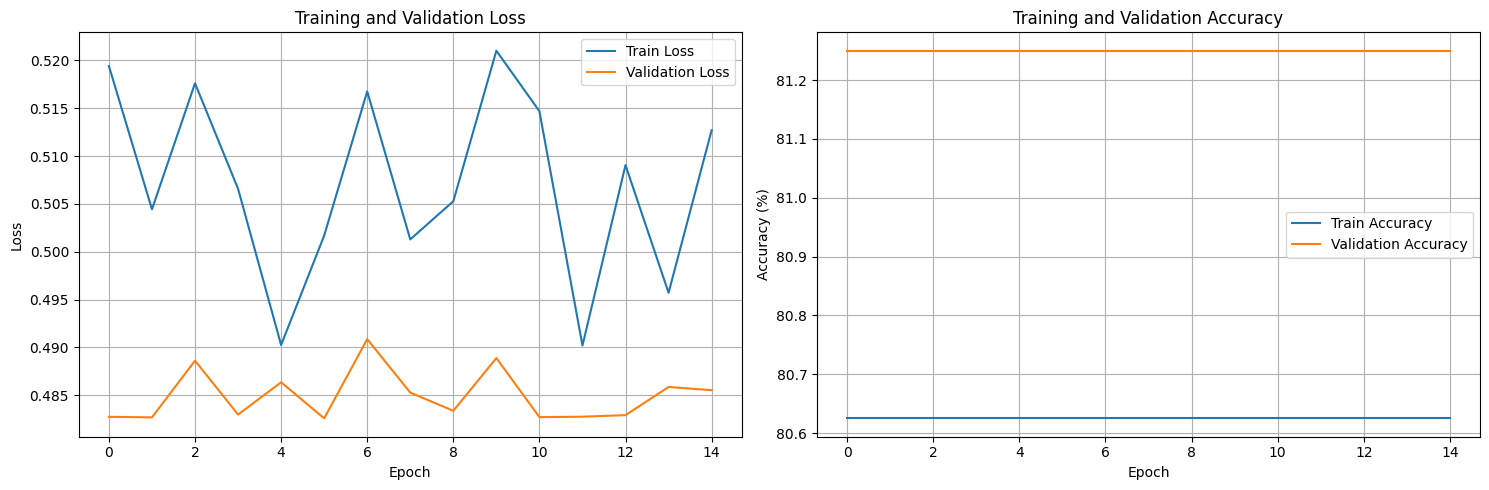

In [ ]:
# Vẽ biểu đồ kết quả training
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Đã load model tốt nhất!


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bjjbwsqjir.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/esnntzzajv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/avssvvsdhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cgvrgibpfo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bnjcdrfuov.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Evaluating:  10%|█         | 1/10 [00:02<00:23,  2.57s/it]

Lỗi khi xử lý video deepfake_data/train_sample_videos/crktehraph.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bvgwelbeof.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Evaluating:  20%|██        | 2/10 [00:02<00:09,  1.19s/it]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dsgpbgsrdm.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bzythlfnhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bmbbkwmxqj.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aipfdnwpoo.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ebkzwjgjhq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Evaluating:  30%|███       | 3/10 [00:04<00:10,  1.44s/it]

Lỗi khi xử lý video deepfake_data/train_sample_videos/cxfujlvsuw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/coadfnerlk.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Evaluating:  40%|████      | 4/10 [00:04<00:05,  1.06it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/bilnggbxgu.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cglxirfaey.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/caifxvsozs.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dzieklokdr.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dqppxmoqdl.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Evaluating:  50%|█████     | 5/10 [00:06<00:05,  1.12s/it]

Lỗi khi xử lý video deepfake_data/train_sample_videos/esyrimvzsa.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Evaluating:  60%|██████    | 6/10 [00:06<00:03,  1.23it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/dxuplhwvig.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eiwopxzjfn.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/dsndhujjjb.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cxrfacemmq.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/atkdltyyen.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_vid

Evaluating:  70%|███████   | 7/10 [00:07<00:03,  1.03s/it]

Lỗi khi xử lý video deepfake_data/train_sample_videos/ajwpjhrbcv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/ddjggcasdw.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/eqjscdagiv.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


Evaluating:  80%|████████  | 8/10 [00:08<00:01,  1.28it/s]

Lỗi khi xử lý video deepfake_data/train_sample_videos/eebserckhh.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/cdbsbdymzd.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/brwrlczjvi.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/bgwmmujlmc.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method
Lỗi khi xử lý video deepfake_data/train_sample_videos/aettqgevhz.mp4: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodLỗi khi xử lý video deepfake_data/train_sample_vide

Evaluating: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


KẾT QUẢ ĐÁNH GIÁ MODEL
Accuracy: 0.8125
AUC Score: 0.5000

Classification Report:
              precision    recall  f1-score   support

        REAL       0.00      0.00      0.00        15
        FAKE       0.81      1.00      0.90        65

    accuracy                           0.81        80
   macro avg       0.41      0.50      0.45        80
weighted avg       0.66      0.81      0.73        80

Confusion Matrix:
[[ 0 15]
 [ 0 65]]


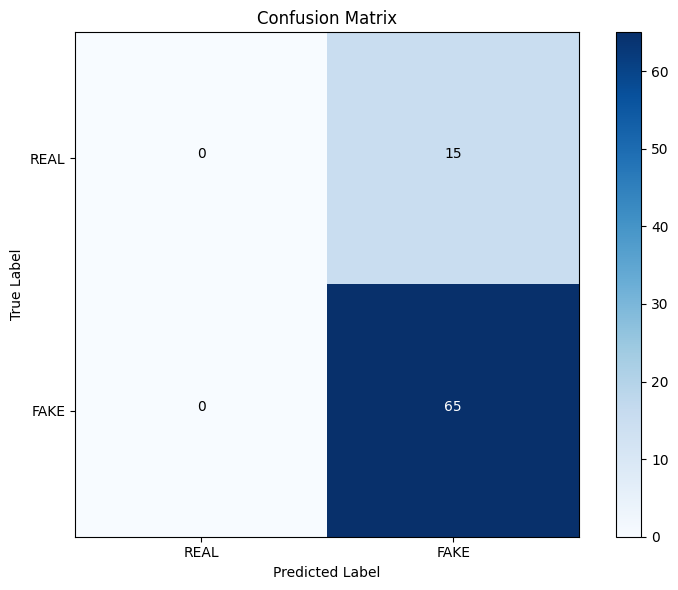

In [ ]:
# Đánh giá model
def evaluate_model(model, val_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for faces, labels in tqdm(val_loader, desc='Evaluating'):
            faces = faces.to(device)
            labels = labels.to(device)

            outputs = model(faces)
            probabilities = outputs.cpu().numpy()
            predictions = (outputs > 0.5).float().cpu().numpy()

            all_probabilities.extend(probabilities)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

# Load model tốt nhất
model.load_state_dict(torch.load('best_deepfake_model.pth'))
print("Đã load model tốt nhất!")

# Đánh giá
y_true, y_pred, y_prob = evaluate_model(model, val_loader, device)

# Tính các metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

print("\n" + "="*50)
print("KẾT QUẢ ĐÁNH GIÁ MODEL")
print("="*50)

accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['REAL', 'FAKE']))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['REAL', 'FAKE'])
plt.yticks(tick_marks, ['REAL', 'FAKE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Thêm số vào ô
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()